# lisabeta: tutorial for basics of the interface and MBHB sky localization

This notebook describes basics about lisabeta, a package for gravitational wave data analysis for the instrument LISA.

lisabeta is now publicly available here:

[https://gitlab.in2p3.fr/marsat/lisabeta](https://gitlab.in2p3.fr/marsat/lisabeta)
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/SylvainMarsat/lisabeta_sky_tutorial/blob/main/lisa_mbhb_sky_tutorial.ipynb)

## Installation on Google Colab

In [ ]:
!apt-get install libgsl-dev
!gsl-config --prefix
!apt-get install fftw3-dev

In [ ]:
!apt-get install cm-super dvipng texlive-latex-extra texlive-latex-recommended #needed to support tex in matplotlib (takes just over 1 min)

In [ ]:
!git clone --recursive --depth=1 https://gitlab.in2p3.fr/marsat/lisabeta.git lisabeta_code
!if grep -q default lisabeta/lisabeta-py310.yml; then sed -i.bak -e '4d;' lisabeta_code/lisabeta-py310.yml; fi;
!sed -i.bak 's\/path/to/gsl\/usr:/usr/local\g;s\:/path/to/LDC/ldc/common/constants\\' lisabeta_code/setup.cfg

In [ ]:
%pip install ./lisabeta_code

## Imports

In [1]:
import os
import h5py
import itertools
import copy
import numpy as np
import scipy
import json
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm

from astropy.cosmology import Planck15 as cosmo

In [2]:
import lisabeta
import lisabeta.pyconstants as pyconstants
import lisabeta.tools.pytools as pytools
import lisabeta.tools.pyspline as pyspline
import lisabeta.tools.pyoverlap as pyoverlap
import lisabeta.lisa.pyresponse as pyresponse
import lisabeta.lisa.snrtools as snrtools
import lisabeta.lisa.pyLISAnoise as pyLISAnoise
import lisabeta.lisa.lisa as lisa
import lisabeta.lisa.lisatools as lisatools
import lisabeta.lisa.lisa_fisher as lisa_fisher
import lisabeta.utils.plotutils as plotutils

/Users/marsat/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/waveforms/bbh/lalsim_wrap.py:10: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [3]:
np.set_printoptions(legacy='1.25')
%matplotlib inline

# A quick look at the lisabeta interface

## Setting parameters

In [4]:
# Redshift z=6
cosmo.luminosity_distance(6.).value

59046.10457286159

In [5]:
# Physical signal parameters
# NOTE: Lframe is a flag that changes the meaning of several parameters: when on, lambda, beta, psi and Deltat all refer to the LISA-frame
# NOTE: all masses in the code are understood as redshifted, detector-frame masses

params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(6).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [6]:
# Tool to complete the dictionary with other mass/spin combinations
pytools.complete_all_params(params)

{'M': 5000000.0,
 'q': 4.0,
 'chi1': 0.7,
 'chi2': 0.4,
 'Deltat': 0.0,
 'dist': 59046.10457286159,
 'inc': 1.0471975511965976,
 'phi': 1.2,
 'lambda': 0.5,
 'beta': 0.9,
 'psi': 2.7,
 'Lframe': True,
 'm1': 4000000.0,
 'm2': 1000000.0,
 'Mchirp': 1665106.4148037464,
 'eta': 0.16,
 'chis': 0.55,
 'chia': 0.14999999999999997,
 'chip': 0.6399999999999999,
 'chim': 0.4799999999999999,
 'chiPN': 0.5808141592920354}

In [7]:
# Parameters for the waveform generation and other options

waveform_params = {
    
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 2.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fstart22": None,
    "fend22": None,
    "tmin": None,
    "tmax": None,
    
    # Waveform approximant and set of harmonics to use (None to use all available)
    "approximant": "IMRPhenomXHM",
    "modes": None,
    
    # LISA response options
    "TDI": "TDIAET",
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

## Waveform and response generation function

In [11]:
# Generate waveform and LISA transfer functions separately
wftdi = lisa.GenerateLISATDI_SMBH(params, **waveform_params)

In [9]:
%timeit lisa.GenerateLISATDI_SMBH(params, **waveform_params)

1 ms ± 22.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
wftdi.keys()

dict_keys(['params', 'modes', 'fpeak', 'Mfinal', 'chifinal', (2, 2), (2, 1), (3, 3), (3, 2), (4, 4)])

In [13]:
# List of modes
wftdi['modes']

[(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)]

In [16]:
# Each mode has its own amplitude, phase, Doppler phase, transfer functions
wftdi[(2,2)].keys()

dict_keys(['freq', 'amp', 'phase', 'tf', 'phaseRdelay', 'transferL1', 'transferL2', 'transferL3'])

In [17]:
# The data is represented on a sparse set of frequencies
wftdi[(2,2)]['freq'].shape[0]

308

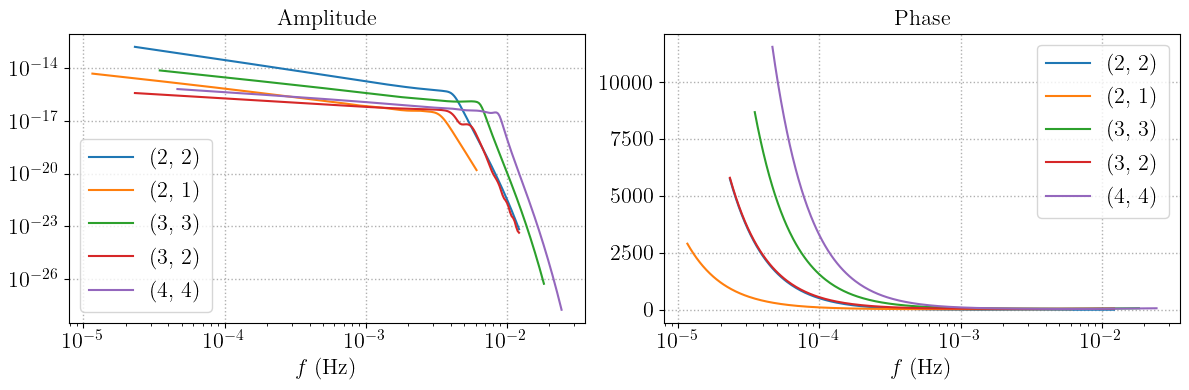

In [19]:
# Amplitude and phase of the hlm in the waveform

fig, axs = plt.subplots(1,2, figsize=[12,4])
for lm in wftdi['modes']:
    axs[0].plot(wftdi[lm]['freq'], np.abs(wftdi[lm]['amp']), label=str(lm))
    axs[1].plot(wftdi[lm]['freq'], np.abs(wftdi[lm]['phase']), label=str(lm))
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
axs[0].set_yscale('log')
axs[0].legend(loc='lower left')
axs[1].legend(loc='upper right')
axs[0].set_title(r'Amplitude')
axs[1].set_title(r'Phase')
fig.tight_layout()

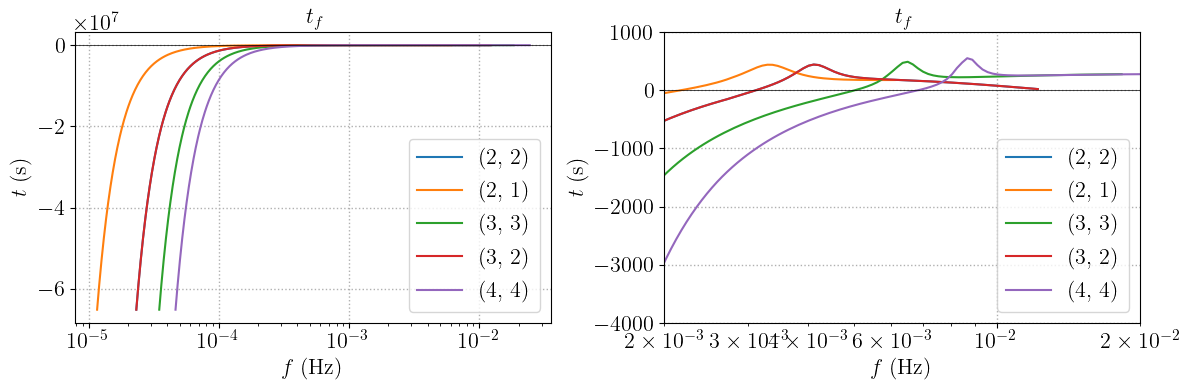

In [33]:
# Time-of-frequency correspondence

fig, axs = plt.subplots(1,2, figsize=[12,4])
for lm in wftdi['modes']:
    axs[0].plot(wftdi[lm]['freq'], wftdi[lm]['tf'], label=str(lm))
    axs[1].plot(wftdi[lm]['freq'], wftdi[lm]['tf'], label=str(lm))
    axs[1].set_xlim(2e-3, 2e-2)
    axs[1].set_ylim(-4e3, 1e3)
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_ylabel(r'$t \; (\mathrm{s})$')
    axs[i].axhline(0., c='k', lw=0.5)
axs[0].legend(loc='lower right')
axs[1].legend(loc='lower right')
axs[0].set_title(r'$t_f$')
axs[1].set_title(r'$t_f$')
fig.tight_layout()

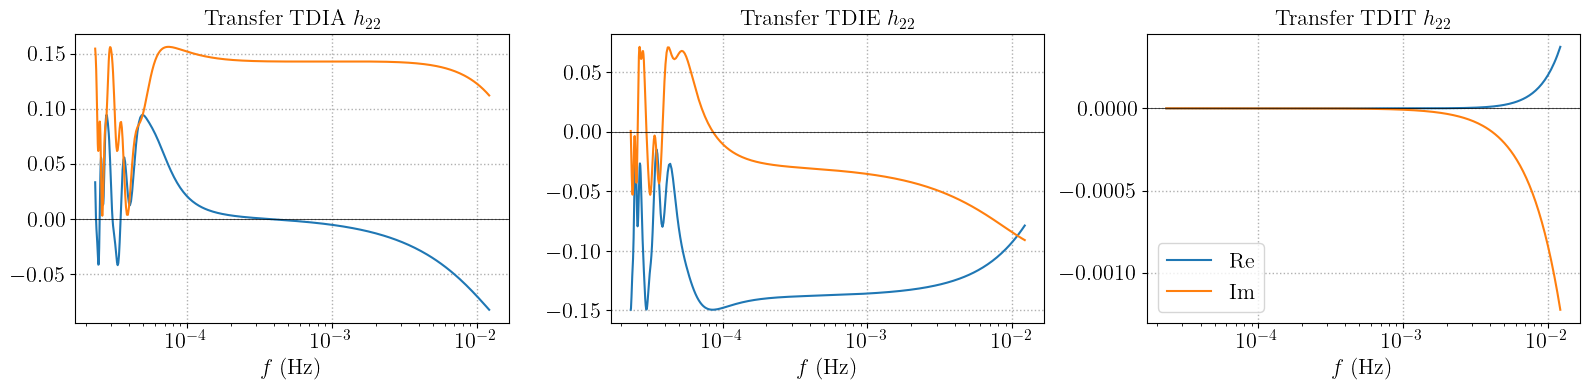

In [24]:
# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    axs[i].plot(wftdi[lm]['freq'], np.real(wftdi[lm][transferstr]) * rescaling, label='Re')
    axs[i].plot(wftdi[lm]['freq'], np.imag(wftdi[lm][transferstr]) * rescaling, label='Im')
    axs[i].set_xscale('log')
    axs[i].axhline(0., c='k', lw=0.5)
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
axs[2].legend(loc='lower left')
fig.tight_layout()

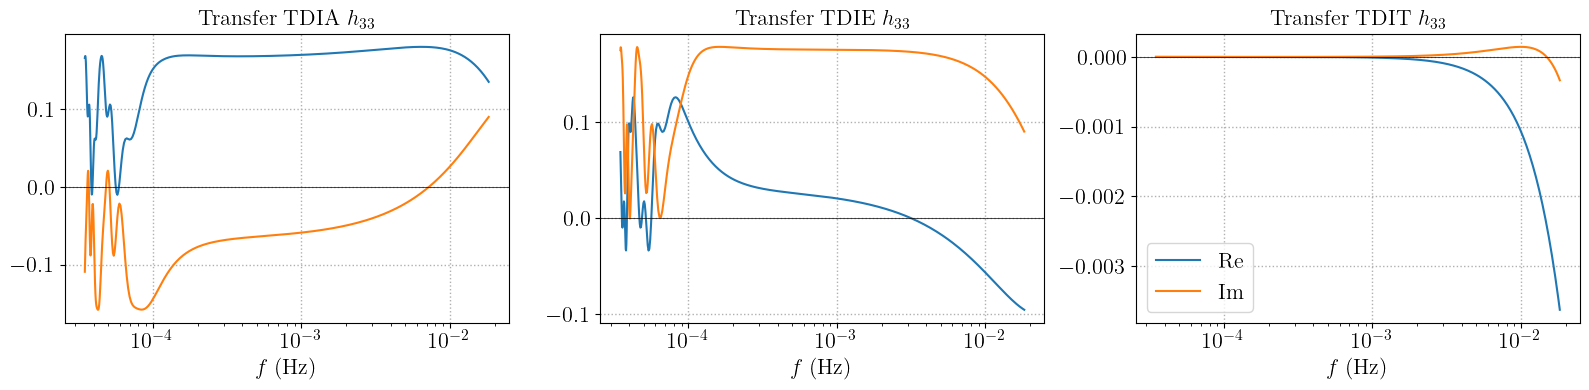

In [34]:
# Transfer functions, mode h33 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{33}$', 'Transfer TDIE $h_{33}$', 'Transfer TDIT $h_{33}$']
lm = (3,3)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[(3,3)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    axs[i].plot(wftdi[lm]['freq'], np.real(wftdi[lm][transferstr]) * rescaling, label='Re')
    axs[i].plot(wftdi[lm]['freq'], np.imag(wftdi[lm][transferstr]) * rescaling, label='Im')
    axs[i].set_xscale('log')
    axs[i].axhline(0., c='k', lw=0.5)
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
axs[2].legend(loc='lower left')
fig.tight_layout()

## Compute SNR

### Basic SNR

In [33]:
# Compute the SNR (h|h) summed over 3 TDI channels
snrtools.lisa_mbhb_snr(params, **waveform_params)

980.5674891476933

In [34]:
%timeit snrtools.lisa_mbhb_snr(params, **waveform_params)

3.9 ms ± 154 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Cumulative SNR(t)

In [71]:
# Computing the cumulative SNR for 22 mode only, done at once

waveform_params_22 = copy.deepcopy(waveform_params)
waveform_params_22['modes'] = [(2,2)]

snrcumul = lisa.CumulSNRLISATDI_SMBH(params, **waveform_params_22)

mask = (snrcumul['tf'] < 0) & (snrcumul['SNRcumul'] > 0)

In [74]:
# Computing the cumulative SNR with HM, changing the time cut

waveform_params_noDeltatL = copy.deepcopy(waveform_params)
waveform_params_noDeltatL.pop('DeltatL_cut')

time_to_merger_vals = -snrcumul['tf'][mask]
snr_tcut_vals = np.zeros_like(time_to_merger_vals)
for i,tcut in enumerate(tqdm(time_to_merger_vals)):
    snr_tcut_vals[i] = snrtools.lisa_mbhb_snr(params, time_to_merger_cut=tcut, **waveform_params_noDeltatL)

100%|███████████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 321.44it/s]


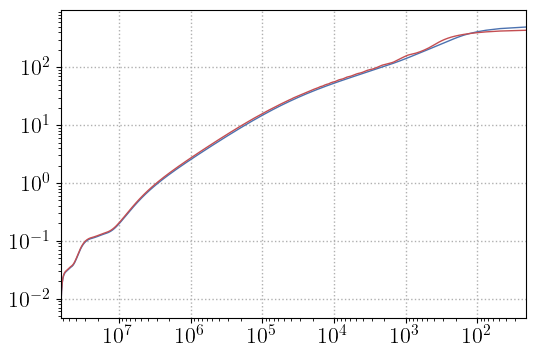

<Figure size 800x400 with 0 Axes>

In [75]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lloglogplot(ax, [-snrcumul['tf'][mask], snrcumul['SNRcumul'][mask]], [time_to_merger_vals, snr_tcut_vals])

In [79]:
# Other functions

snrtools.lisa_SNRoft?

Signature: snrtools.lisa_SNRoft(times, params, pad_zero=False, **waveform_params)
Docstring: <no docstring>
File:      ~/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/lisa/snrtools.py
Type:      function

In [80]:
# Other functions

snrtools.lisa_tofSNR?

Signature: snrtools.lisa_tofSNR(SNR, params, **waveform_params)
Docstring: <no docstring>
File:      ~/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/lisa/snrtools.py
Type:      function

### SNR contribution of different HM

In [38]:
# More detailed interface: also stores SNR mode-by-mode (and some reconditioning of the waveform)
tdisignal = lisa.GenerateLISATDISignal_SMBH(params, **waveform_params)

In [36]:
# Total SNR (all channels, all modes)
tdisignal['SNR']

980.5674891476933

In [39]:
tdisignal.keys()

dict_keys(['SNR', 'SNR2modematrix', 'wftdi', 'tdi', 'weightedtdi'])

In [40]:
# Matrix of (lm,l'm') mode contributions to the SNR^2
tdisignal['SNR2modematrix']

{'modes': [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)],
 'matrix': array([[ 7.43178659e+05, -1.37740532e+04,  6.81625943e+03,
         -3.07874367e+04, -4.19437902e+02],
        [-1.37740480e+04,  1.67179091e+03,  3.86674146e+02,
          8.40647342e+02,  2.53494608e+01],
        [ 6.81579719e+03,  3.86630864e+02,  2.43301867e+05,
         -1.78573974e+01,  3.70860832e+02],
        [-3.07874367e+04,  8.40631505e+02, -3.79139868e+01,
          2.39911299e+03, -6.02706394e+01],
        [-4.19425601e+02,  2.53458344e+01,  3.70172684e+02,
         -6.13179585e+01,  4.42219996e+04]])}

In [41]:
# SNR in individual modes
list(zip(tdisignal['SNR2modematrix']['modes'], np.sqrt(np.diag(tdisignal['SNR2modematrix']['matrix']))))

[((2, 2), 862.0781048195975),
 ((2, 1), 40.887539832854),
 ((3, 3), 493.25639099689135),
 ((3, 2), 48.98074104455781),
 ((4, 4), 210.2902745699225)]

/tmp/ipykernel_61013/1151499152.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])
/tmp/ipykernel_61013/1151499152.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])


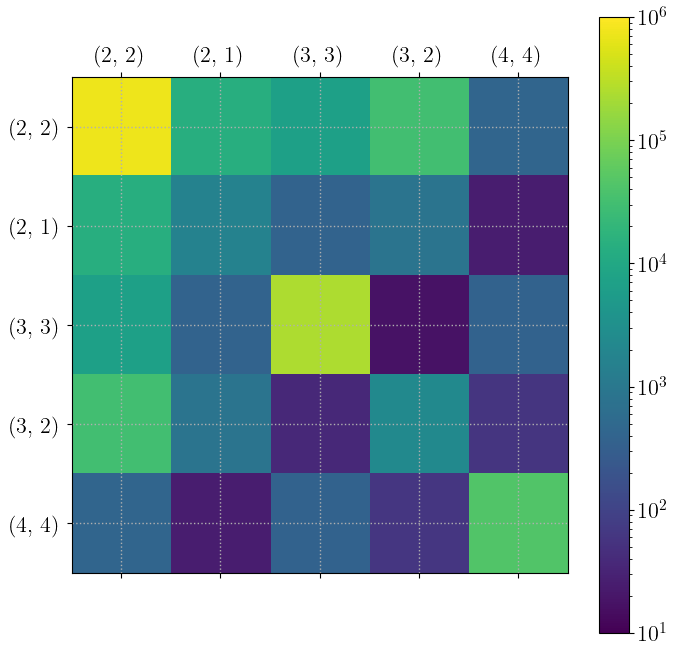

In [50]:
# Plotting the matrix of (h_lm | h_l'm') in log-scale (cross-terms can have either sign)

fig, ax = plt.subplots(1,1, figsize=[8,8])
cax = ax.matshow(np.abs(tdisignal['SNR2modematrix']['matrix']), interpolation='nearest', norm=mpl.colors.LogNorm(vmin=10., vmax=1e6))
ax.set_xticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])
ax.set_yticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])

fig.colorbar(cax)

## Fisher matrix

In [40]:
list_params = ['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']
params_complete = pytools.complete_mass_params(params)
params_complete = pytools.complete_spin_params(params_complete)

# Use frequency grid adjusted to inspiral phasing at low frequencies, logarithmic at high frequencies, with default number of points
freqs = ['nyquist_log', None]

# Do the computation in the L-frame
Lframe = True

steps = lisa_fisher.get_default_steps_smbh(params['M'])

steps

{'M': 4.999999999999999e-06,
 'Mchirp': 4.999999999999999e-06,
 'm1': 4.999999999999999e-06,
 'm2': 4.999999999999999e-06,
 'q': 0.00010000000000000009,
 'eta': 9.99999999999998e-06,
 'chi1': 9.99999999999998e-06,
 'chi2': 9.99999999999998e-06,
 'chip': 9.99999999999998e-06,
 'chim': 9.99999999999998e-06,
 'chis': 9.99999999999998e-06,
 'chia': 9.99999999999998e-06,
 'chiPN': 9.99999999999998e-06,
 'Deltat': 0.00010000000000000009,
 'dist': 9.99999999999998e-06,
 'inc': 0.00010000000000000009,
 'phi': 0.00010000000000000009,
 'lambda': 0.00010000000000000009,
 'beta': 0.00010000000000000009,
 'psi': 0.00010000000000000009}

In [41]:
%%time
fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=freqs, steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)

CPU times: user 965 ms, sys: 92.6 ms, total: 1.06 s
Wall time: 1.06 s


In [42]:
fishercov.keys()

dict_keys(['params', 'list_params', 'fisher', 'cov', 'Lframe'])

In [43]:
# Fisher covariance matrix, 11*11
fishercov['list_params'], fishercov['cov']

(['M',
  'q',
  'chi1',
  'chi2',
  'Deltat',
  'dist',
  'inc',
  'phi',
  'lambda',
  'beta',
  'psi'],
 array([[ 6.58536230e+06,  1.32905494e+01,  3.23076931e+00,
         -2.04200572e+01, -3.33090915e+03, -1.29669615e+06,
         -2.32936599e+00,  2.77058068e+01,  2.14453470e+01,
         -3.48286458e+01,  1.00903225e+01],
        [ 1.32905494e+01,  3.38064022e-05,  6.87014198e-06,
         -5.35499802e-05, -7.57139094e-03, -3.46644063e+00,
         -6.63605016e-06,  5.69821508e-05,  5.98942191e-05,
         -9.13710345e-05,  2.98525079e-05],
        [ 3.23076931e+00,  6.87014198e-06,  1.98111125e-06,
         -1.33432604e-05, -1.81232798e-03, -8.70471756e-01,
         -1.19957283e-06,  1.47753984e-05,  1.20835251e-05,
         -2.29633683e-05,  4.67674063e-06],
        [-2.04200572e+01, -5.35499802e-05, -1.33432604e-05,
          1.14654154e-04,  1.34638482e-02,  7.52639465e+00,
          1.12456462e-05, -9.68808806e-05, -1.09725724e-04,
          1.95105579e-04, -4.63045638e-05]

In [44]:
# sigma(M) / M
('M', np.sqrt(fishercov['cov'][0,0])/params_complete['M'])

('M', 0.0005132392150666697)

In [45]:
# sigma(q)
('q', np.sqrt(fishercov['cov'][1,1]))

('q', 0.005814327318626175)

In [46]:
# sigma(D) / D
('dist', np.sqrt(fishercov['cov'][5,5])/params_complete['dist'])

('dist', 0.014630358763420363)

In [47]:
# A helper function to compute the sky area at a certain probability level (or n-sigma level) from the Fisher covariance
lisatools.sky_area_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

14.664330043803254

## Likelihood

In [48]:
template_params = params.copy()
template_params['q'] *= (1 + 1e-3)

In [33]:
%%time

# Fast heterodyne likelihood, based on residuals from a reference signal -- can also accomodate real data
# Has a startup cost were pre-computations occur
likelihood_residuals = lisa.LikelihoodLISASMBH_LinearResiduals(params, ngrid=128, **waveform_params)

CPU times: user 14 s, sys: 394 ms, total: 14.4 s
Wall time: 14.6 s


In [34]:
%%time
likelihood_residuals.lnL(template_params)

CPU times: user 2.05 ms, sys: 138 μs, total: 2.19 ms
Wall time: 2.18 ms


-3.8331906090905563

In [35]:
qvals = np.linspace(params['q'] - 1e-2, params['q'] + 1e-2)
likelihoodvals = np.zeros_like(qvals)
for i,q in enumerate(tqdm(qvals)):
    temp_params = params.copy()
    temp_params['q'] = q
    likelihoodvals[i] = likelihood_residuals.lnL(temp_params)

100%|█████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 577.34it/s]


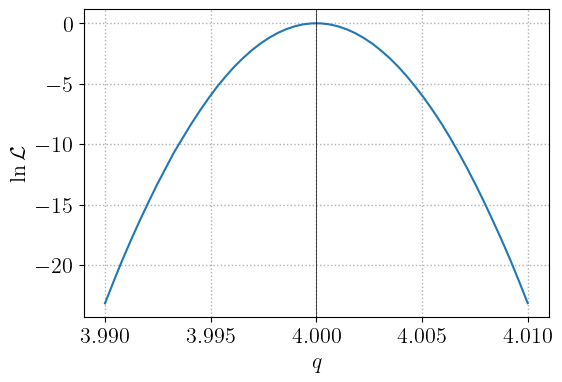

In [37]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(qvals, likelihoodvals)
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$\ln \mathcal{L}$')
ax.axvline(params['q'], c='k', lw=0.5)

# Interface for Bayesian parameter estimation

Sampler `ptemcee` available at `https://github.com/SylvainMarsat/ptemcee`, directly cloned locally as submodule if using git clone --recursive

## Interface and run parameters

Example `.json` submission file:
<code>{
  "source_params": {
    "M": 4e6,
    "q": 3.0,
    "chi1": 0.5,
    "chi2": 0.2,
    "Deltat": 0.0,
    "dist": 3.65943e+04,
    "inc": 1.0471975511965976,
    "phi": 1.2,
    "lambda": 0.8,
    "beta": 1.0471975511965976,
    "psi": 1.7,
    "Lframe": true
  },
  "waveform_params": {
    "minf": 1e-5,
    "maxf": 0.5,
    "t0": 0.0,
    "timetomerger_max": 1.0,
    "fend": null,
    "tmin": null,
    "tmax": null,
    "phiref": 0.0,
    "fref_for_phiref": 0.0,
    "tref": 0.0,
    "fref_for_tref": 0.0,
    "force_phiref_fref": true,
    "toffset": 0.0,
    "modes": null,
    "TDI": "TDIAET",
    "acc": 1e-4,
    "order_fresnel": 0,
    "approximant": "IMRPhenomHM",
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": false,
    "TDIrescaled": true,
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": false,
        "WDduration" : 0.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  },
  "prior_params": {
    "list_params": ["M", "q", "chi1", "chi2", "Deltat", "dist", "inc", "phi", "lambda", "beta", "psi"],
    "infer_params": ["M", "q", "chi1", "chi2", "Deltat", "dist", "inc", "phi", "lambda", "beta", "psi"],
    "params_range": [[1e6, 1e7], [1., 10.], [-1.0, 1.0], [-1.0, 1.0], [-600.0, 600.0], [10e3, 100e3], [], [], [], [], []],
    "prior_type": ["uniform", "uniform", "uniform", "uniform", "uniform", "uniform", "sin", "uniform", "uniform", "cos", "uniform"],
    "wrap_params": null
  },
  "run_params": {
    "out_dir": "/Users/marsat/Projects/lisabeta/lisabeta/examples/ptemcee_smbh/",
    "out_name": "smbh_example",
    "sampler": "ptemcee",
    "sample_Lframe": true,
    "multimodal": true,
    "multimodal_pattern": "8modes",
    "p_jump": 0.5,
    "likelihood_method": "residuals",
    "likelihood_residuals_ngrid": 128,
    "skip_fisher": false,
    "init_method": "fisher",
    "init_scale_cov": 1.0,
    "zerolike": false,
    "n_temps": 10,
    "temp_max": null,
    "n_walkers": 64,
    "n_iter": 4000,
    "burn_in": 1000,
    "autocor_method": "autocor_new",
    "thin_samples": true,
    "upsample": 1,
    "seed": null,
    "print_info": true,
    "n_iter_info": 50,
    "output": true,
    "output_raw": true
  }
}
</code>

Run with `python <lisabeta>/lisabeta/inference/ptemcee_smbh.py example.json`

## Load results

In [100]:
subsdir = '/Users/marsat/Projects/lisabeta/examples/'
#datadir = '/Users/marsat/Projects/lisabeta/examples/'
datadir = '/Users/marsat/Projects/lisabeta/examples/long/'

In [101]:
subfile = subsdir + 'smbh_example_cc.json'
postfile = datadir + 'smbh_example.h5'

params_post = plotutils.load_params_posterior_lisa_smbh(subfile, postfile)

post_raw_file = datadir + 'smbh_example_raw.h5'

post_raw = {}
with h5py.File(post_raw_file, 'r') as hf:
    for p in params_post['prior_params']['infer_params']:
        post_raw[p] = hf[p][:]
    post_raw['lnL'] = hf['lnlike'][:]

In [52]:
params_post.keys()

dict_keys(['fishercov', 'injparams_SSBframe', 'injparams_Lframe', 'waveform_params', 'prior_params', 'run_params', 'post'])

In [53]:
params_post['post'].keys()

dict_keys(['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi', 'lnL', 'lnpost', 'Lframe', 'm1', 'm2', 'Mchirp', 'eta', 'chis', 'chia', 'chip', 'chim', 'chiPN'])

## Likelihood values

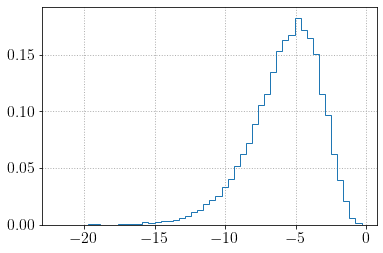

In [82]:
# We cheated with Fisher initialization, chains are good from the beginning !
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(params_post['post']['lnL'], histtype='step', density=True);

In [58]:
def plot_postraw_lnL_trace(post_raw, rangey=None, title=''):

    nwalkers = post_raw['lnL'].shape[0]
    nsteps = post_raw['lnL'].shape[1]

    #Threshold to eliminate the -1e99 values that mess up plots
    masks = [post_raw['lnL'][i] > -1e12 for i in range(nwalkers)]
    fig, ax = plt.subplots(1,1, figsize=[16,4])
    plotutils.llogplot(ax, *[[np.arange(nsteps)[masks[i]], -post_raw['lnL'][i][masks[i]]] for i in range(nwalkers)], rangey=rangey)

    ax.set_xlabel(r'$\mathrm{Steps}$')
    ax.set_ylabel(r'$-\ln \mathcal{L}$')
    ax.set_title(title)

    return fig

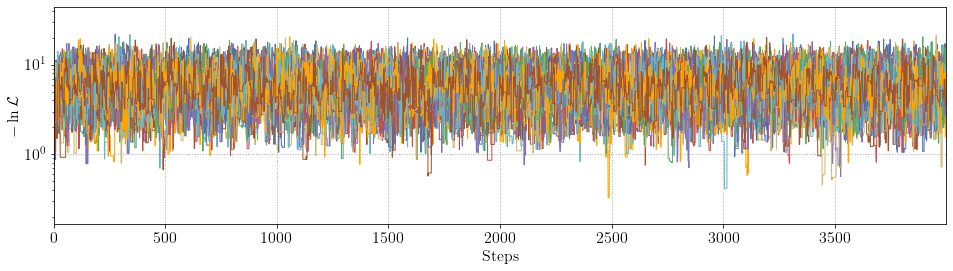

<Figure size 576x288 with 0 Axes>

In [83]:
# We cheated with Fisher initialization, chains are good from the beginning !
plot_postraw_lnL_trace(post_raw);

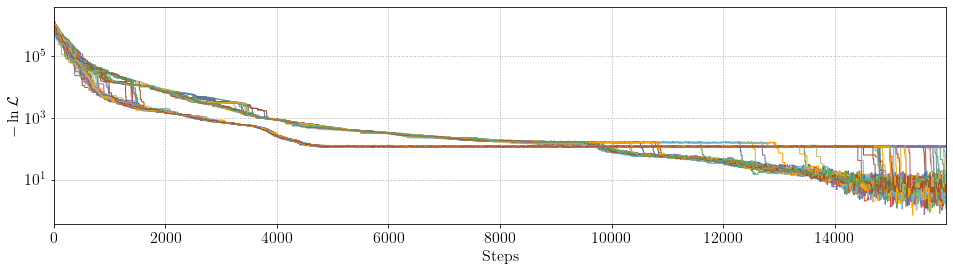

<Figure size 576x288 with 0 Axes>

In [103]:
# WARNING: at present burn-in hard for loud signals, can get stuck in secondary maxima (PT helps)

plot_postraw_lnL_trace(post_raw);

## Posterior

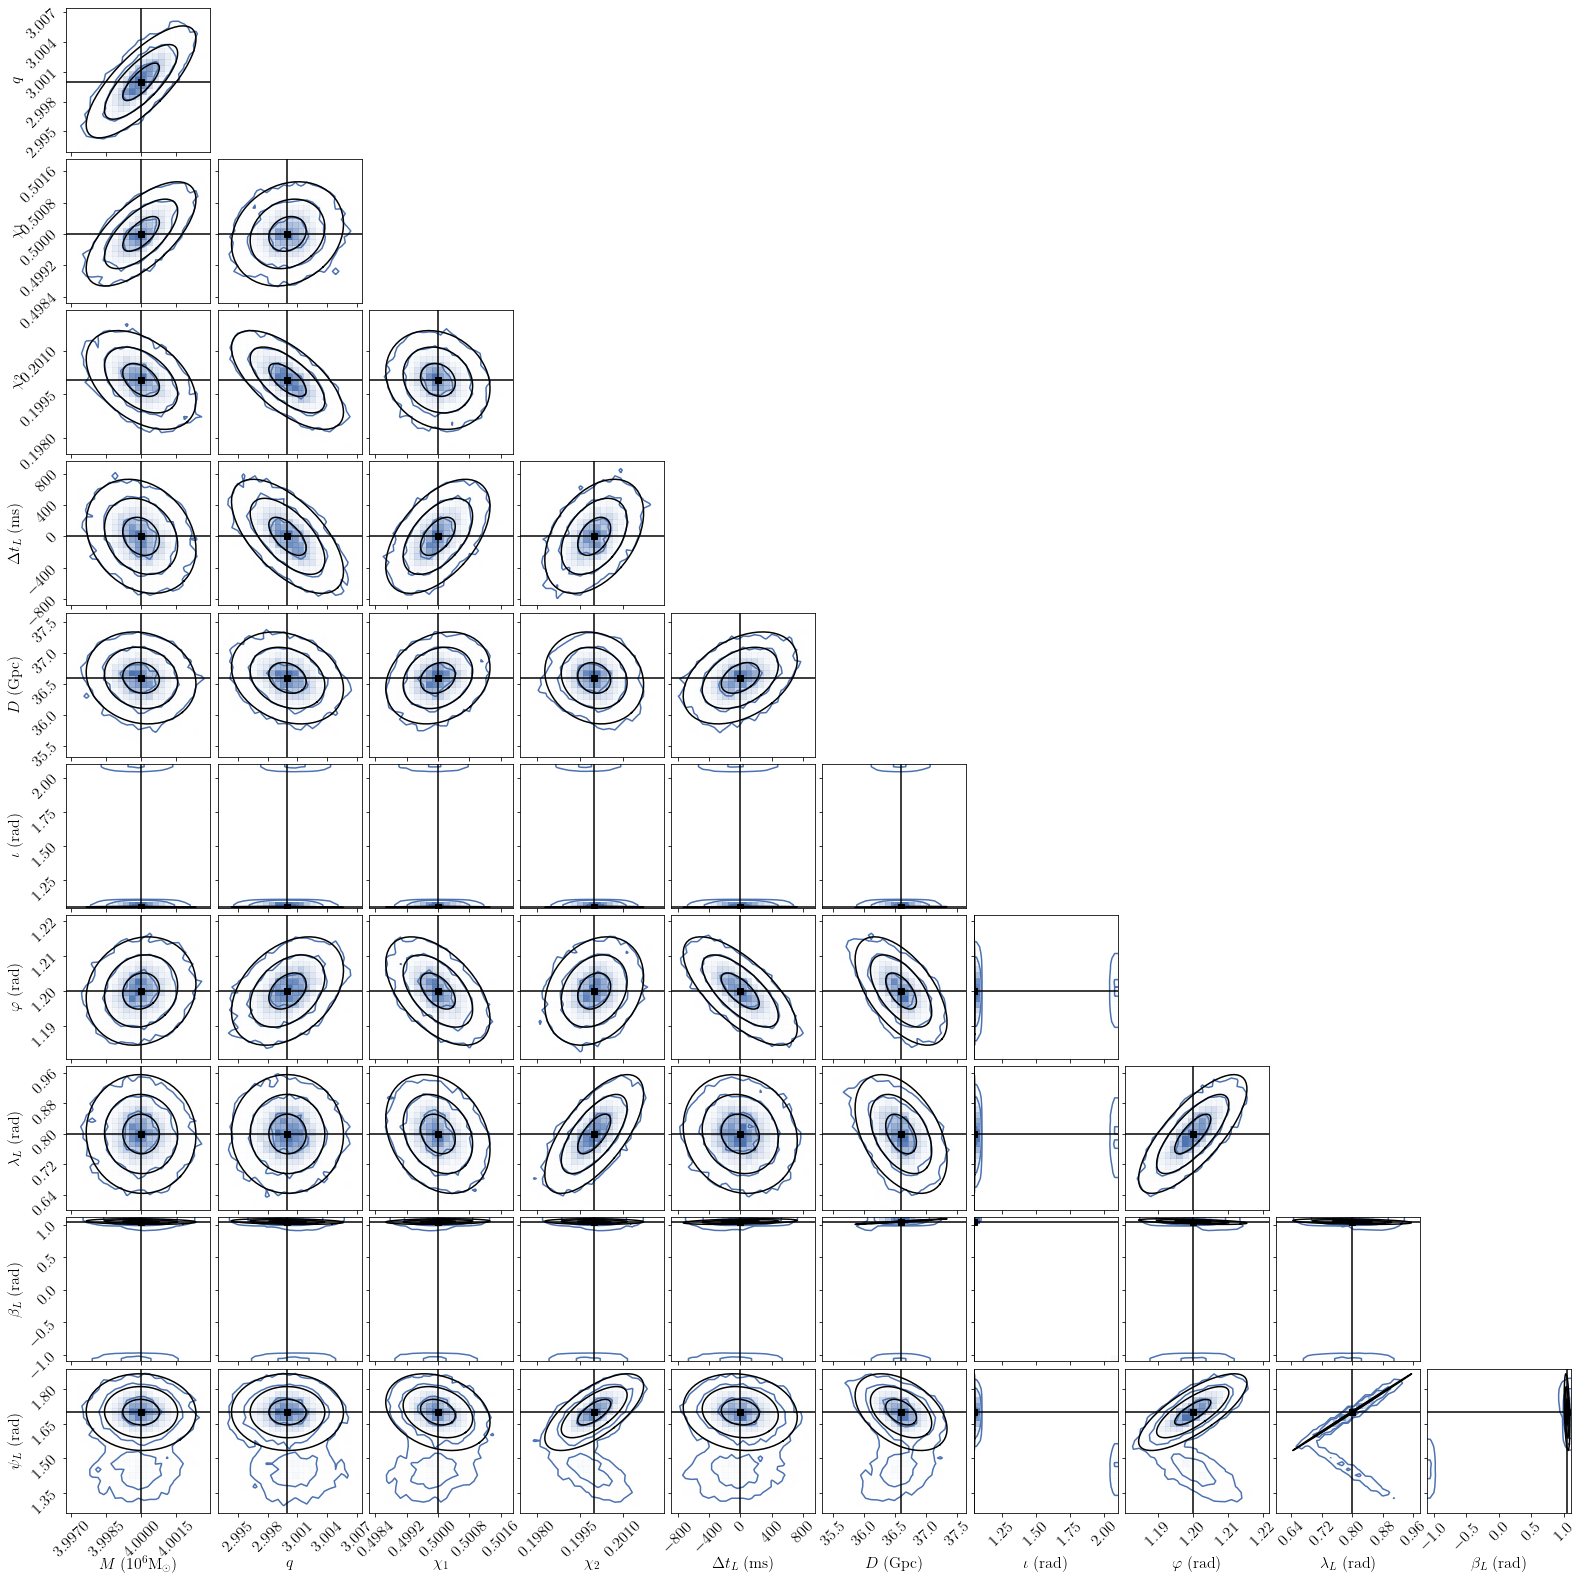

In [85]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], params_post['post'], output=False, histograms=True, fisher=True, fishercov=params_post['fishercov'], params=['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi'], Lframe=True, color=plotutils.plotpalette[0], cov_color='k', show_truths=True, truth_color='k', bins=25, show_histograms=False, plot_datapoints=False);

# Noise and choice of TDI variables

## Instrumental noise and confusion background interface

In [8]:
# Format for the noise
waveform_params['LISAnoise']

{'InstrumentalNoise': 'SciRDv1',
 'WDbackground': True,
 'WDduration': 4.0,
 'lowf_add_pm_noise_f0': 0.0,
 'lowf_add_pm_noise_alpha': 2.0}

In [9]:
# Evaluate noise with different WD backgrounds (different LISA durations)

freqs = np.geomspace(1e-6, 1., 10000)

waveform_params_WD = {}
for duration in [1,4,10]:
    waveform_params_WD[duration] = copy.deepcopy(waveform_params)
    waveform_params_WD[duration]['LISAnoise']['WDbackground'] = True
    waveform_params_WD[duration]['LISAnoise']['WDduration'] = duration
waveform_params_WD[0] = copy.deepcopy(waveform_params)
waveform_params_WD[0]['LISAnoise']['WDbackground'] = False

psd_WD = {}
for k in waveform_params_WD.keys():
    psd_WD[k] = pyLISAnoise.evaluate_AET_psd(freqs, TDIT=True, **waveform_params_WD[k])

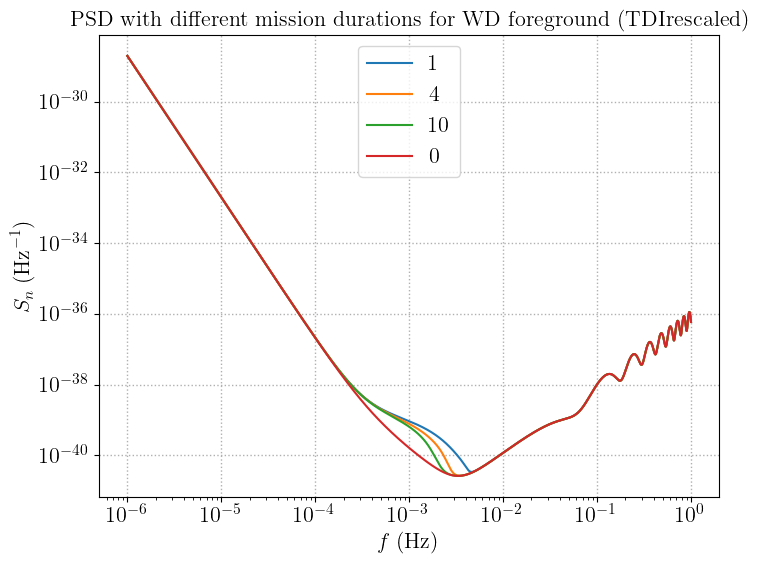

In [10]:
fig, ax = plt.subplots(1,1, figsize=[8,6])
for k in waveform_params_WD.keys():
    ax.plot(freqs, psd_WD[k]['TDIA'], label=k)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f \; (\mathrm{Hz})$')
ax.set_ylabel(r'$S_n \; (\mathrm{Hz}^{-1})$')
ax.set_title(r'PSD with different mission durations for WD foreground (TDIrescaled)')
ax.legend(loc='upper center')

In [10]:
# Evaluate noise for different TDI variables

freqs = np.geomspace(1e-6, 1., 10000)

waveform_params_TDI = {}
waveform_params_TDI['TDIrescaled'] = copy.deepcopy(waveform_params)
waveform_params_TDI['TDI1'] = copy.deepcopy(waveform_params)
waveform_params_TDI['TDI2'] = copy.deepcopy(waveform_params)

waveform_params_TDI['TDIrescaled']['TDIrescaled'] = True
waveform_params_TDI['TDI1']['TDIrescaled'] = False
waveform_params_TDI['TDI2']['TDIrescaled'] = False

waveform_params_TDI['TDIrescaled']['TDI'] = 'TDIAET'
waveform_params_TDI['TDI1']['TDI'] = 'TDIAET'
waveform_params_TDI['TDI2']['TDI'] = 'TDI2AET'

psd_TDI = {}
for k in waveform_params_TDI.keys():
    psd_TDI[k] = pyLISAnoise.evaluate_AET_psd(freqs, TDIT=True, **waveform_params_TDI[k])

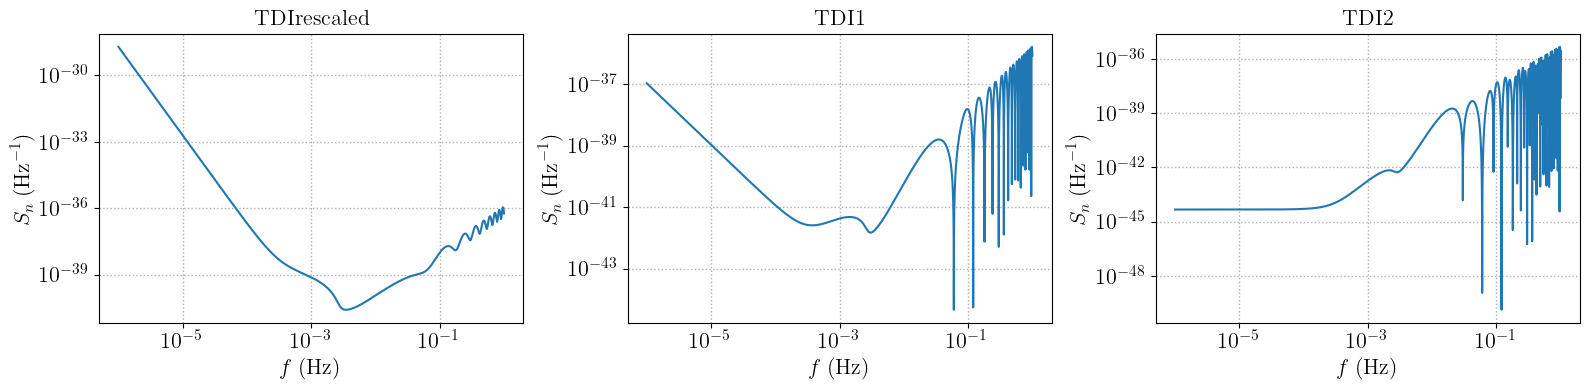

In [19]:
fig, axs = plt.subplots(1,3, figsize=[16,4])
for i,k in enumerate(waveform_params_TDI.keys()):
    axs[i].plot(freqs, psd_TDI[k]['TDIA'], label=k)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_ylabel(r'$S_n \; (\mathrm{Hz}^{-1})$')
    axs[i].set_title(k)
fig.tight_layout()

## Different TDI generations for the signal

In [17]:
freqs_wf = np.geomspace(1e-5, 8e-2, 10000)

tdidata_TDI = {}
for k in waveform_params_TDI.keys():
    tdidata_TDI[k] = lisa.smbh_generate_AET_signal(params, freqs_wf, **waveform_params_TDI[k], output_modes=False)

In [18]:
tdidata_TDI['TDIrescaled'].keys()

dict_keys(['freq', 'TDIA', 'TDIE', 'TDIT'])

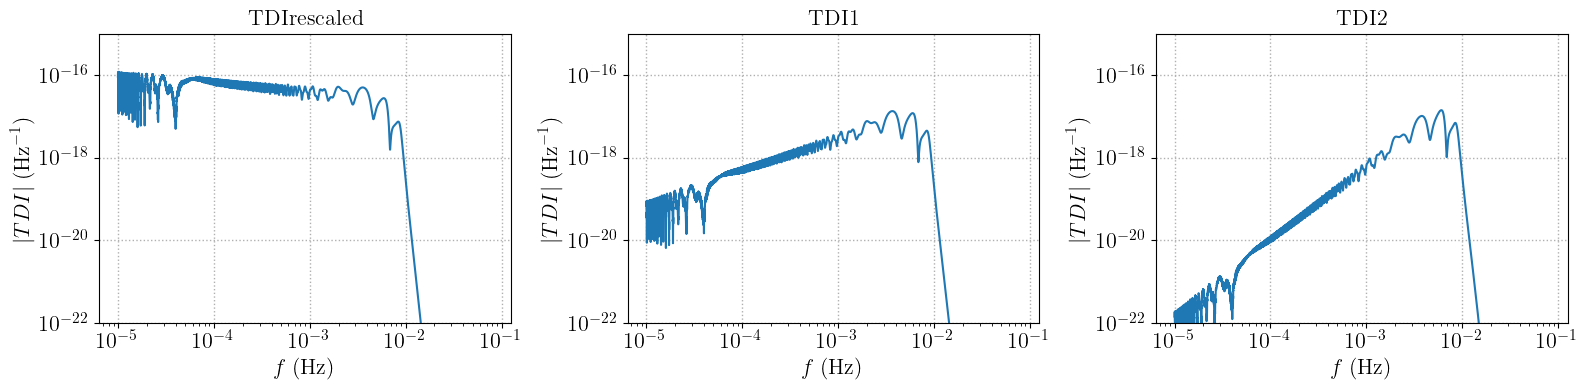

In [21]:
fig, axs = plt.subplots(1,3, figsize=[16,4])
for i,k in enumerate(waveform_params_TDI.keys()):
    axs[i].plot(freqs_wf, np.abs(tdidata_TDI[k]['TDIA']), label=k)
    axs[i].set_ylim(1e-22, 1e-15)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_ylabel(r'$|TDI| \; (\mathrm{Hz}^{-1})$')
    axs[i].set_title(k)
fig.tight_layout()

# Numerics: frequency arrays, overlaps

## Signal representation: over dense or sparse frequency array ?

### Waveform and response

In [29]:
# This is the sparse signal representation chosen in FD: enough to spline-interpolate amplitudes, phases, and TDI transfer functions
wftdi = lisa.GenerateLISATDI_SMBH(params, **waveform_params)
wftdi[(2,2)]['freq'].shape[0]

308

In [36]:
# Exposing the function determining this sparse sampling
fLow = wftdi[(2,2)]['freq'][0]
fHigh = wftdi[(2,2)]['freq'][-1]

pytools.FrequencyGrid(fLow, fHigh, params['M'], params['q'], acc=1e-4, DeltalnMf_max=0.025).get_freq().shape

(308,)

Text(0.5, 1.0, 'Waveform sparse frequency spacing')

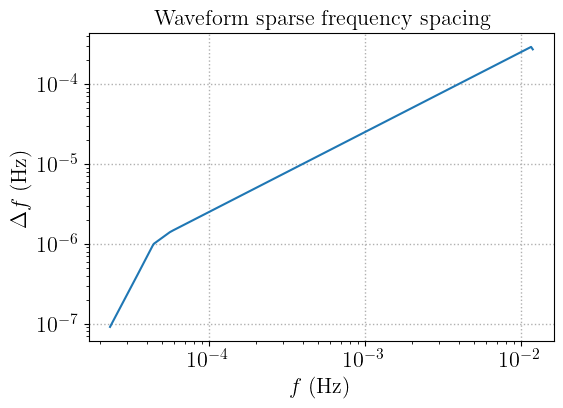

In [33]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(wftdi[(2,2)]['freq'][:-1], np.diff(wftdi[(2,2)]['freq']))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f \; (\mathrm{Hz})$')
ax.set_ylabel(r'$\Delta f \; (\mathrm{Hz})$')
ax.set_title(r'Waveform sparse frequency spacing')

### Frequency grids for the Fisher matrix

In [38]:
# Fisher matrix computation: we use much denser grids to compute the Fisher elements (dh | dh)
list_params = ['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']

In [40]:
waveform_params['modes']

[(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)]

In [43]:
%%time
# Fine spacing, but trying to have a finer sampling at the beginning and coarser at the end -- recommended
fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=['nyquist_log', None], steps=None, list_params=list_params, Lframe=True, **waveform_params)

CPU times: user 915 ms, sys: 87.6 ms, total: 1 s
Wall time: 1.01 s


In [44]:
%%time
# Log-spacing, controlling the total number of points, good enough for short signals -- for quick computations
fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=['log', 10000], steps=None, list_params=list_params, Lframe=True, **waveform_params)

CPU times: user 108 ms, sys: 14.6 ms, total: 123 ms
Wall time: 123 ms


In [45]:
%%time
# Linear-spacing, as we would have in a dataset given by an FFT -- safe but very slow for long signals
fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=['linear', None], steps=None, list_params=list_params, Lframe=True, **waveform_params)

CPU times: user 23.7 s, sys: 5.15 s, total: 28.9 s
Wall time: 29.3 s


### Different likelihoods

In [23]:
template_params = params.copy()
template_params['q'] *= (1 + 1e-3)

In [56]:
%%time
# Historic 0-noise likelihood, moderately fast
likelihood = lisa.LikelihoodLISASMBH(params, **waveform_params)

CPU times: user 6.25 ms, sys: 114 μs, total: 6.36 ms
Wall time: 6.29 ms


In [57]:
%%time

# Faster likelihood, based on residuals from a reference signal -- can also accomodate real data
# Has a startup cost were pre-computations occur
likelihood_residuals = lisa.LikelihoodLISASMBH_LinearResiduals(params, ngrid=128, **waveform_params)

CPU times: user 12.5 s, sys: 322 ms, total: 12.8 s
Wall time: 12.9 s


In [58]:
%%time
likelihood.lnL(template_params)

CPU times: user 10 ms, sys: 1.39 ms, total: 11.4 ms
Wall time: 10.3 ms


-3.842434602614958

In [62]:
%%time
likelihood_residuals.lnL(template_params)

CPU times: user 1.9 ms, sys: 20 μs, total: 1.92 ms
Wall time: 1.91 ms


-3.8331906090905563

In [25]:
%%time

# Slower likelihood, based on basic trapeze integration of overlaps with a dense array of frequencies -- handles naturally real data
likelihood_data = lisa.LikelihoodLISASMBH_Data(params, data=tdidata_TDI['TDIrescaled'], data_noise_only=False, **waveform_params)

CPU times: user 15.6 ms, sys: 3.22 ms, total: 18.8 ms
Wall time: 17.4 ms


In [26]:
%%time
likelihood_data.lnL(template_params)

CPU times: user 13.7 ms, sys: 3.52 ms, total: 17.2 ms
Wall time: 16 ms


-3.8859499559156183

## Fisher matrix: check the steps for numerical derivatives !

In [41]:
# Default settings: (slightly) mass-dependent numerical steps for all parameters
# WARNING: you should always check the sensitivity of the Fisher results to the choice of these numerical steps for the derivatives !
steps = lisa_fisher.get_default_steps_smbh(1e6)
steps

{'M': 1.0000000000000004e-06,
 'Mchirp': 1.0000000000000004e-06,
 'm1': 1.0000000000000004e-06,
 'm2': 1.0000000000000004e-06,
 'q': 0.00010000000000000009,
 'eta': 9.999999999999997e-06,
 'chi1': 9.999999999999997e-06,
 'chi2': 9.999999999999997e-06,
 'chip': 9.999999999999997e-06,
 'chim': 9.999999999999997e-06,
 'chis': 9.999999999999997e-06,
 'chia': 9.999999999999997e-06,
 'chiPN': 9.999999999999997e-06,
 'Deltat': 0.00010000000000000009,
 'dist': 9.999999999999997e-06,
 'inc': 0.00010000000000000009,
 'phi': 0.00010000000000000009,
 'lambda': 0.00010000000000000009,
 'beta': 0.00010000000000000009,
 'psi': 0.00010000000000000009}

# Time-domain interface

In [21]:
# With this interface, we set up carefully the time interval using tmin, tmax, choosing the total length to be a power of 2
dt = 5.
t0_s = 30 * 86400.
N = 16384
N_after = int(np.rint(4*3600. / dt))
tmin_s = t0_s - ((N - N_after)*dt)
tmax_s = t0_s + ((N_after-1)*dt)

tmin = tmin_s / pyconstants.YRSID_SI
tmax = tmax_s / pyconstants.YRSID_SI
t0 = t0_s / pyconstants.YRSID_SI

In [28]:
len(np.arange(tmin_s, tmax_s+dt, dt)), N, N_after, (t0_s - tmin_s)

(16384, 16384, 2880, 67520.0)

In [23]:
waveform_params_td = copy.deepcopy(waveform_params)
waveform_params_td['dt'] = dt
waveform_params_td['t0'] = t0
waveform_params_td['tmin'] = tmin
waveform_params_td['tmax'] = tmax

In [30]:
Mlist = ['1e5', '1e6', '1e7']

for Mstr in Mlist:
    params_M = params.copy()
    params_M['M'] = float(Mstr)
    tdi_td[Mstr] = lisa.GenerateLISATDI_TD_IFFT_SMBH(params_M, whitening=True, output_modes=True, **waveform_params_td)
tdi_td['1e6'].keys()

/Users/marsat/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/lisa/lisa.py:1590: UserWarning: Non-zero values of FD data on [fNyq, fsample] - potential aliasing.
  s_ts = pytools.ifft_real(s_fs, pad=0)
/Users/marsat/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/lisa/lisa.py:1607: UserWarning: Non-zero values of FD data on [fNyq, fsample] - potential aliasing.
  slm_ts = pytools.ifft_real(slm_fs, pad=0)


dict_keys(['TDIA', (2, 2), (2, 1), (3, 3), (3, 2), (4, 4), 't', 'modes', 'freq_bounds'])

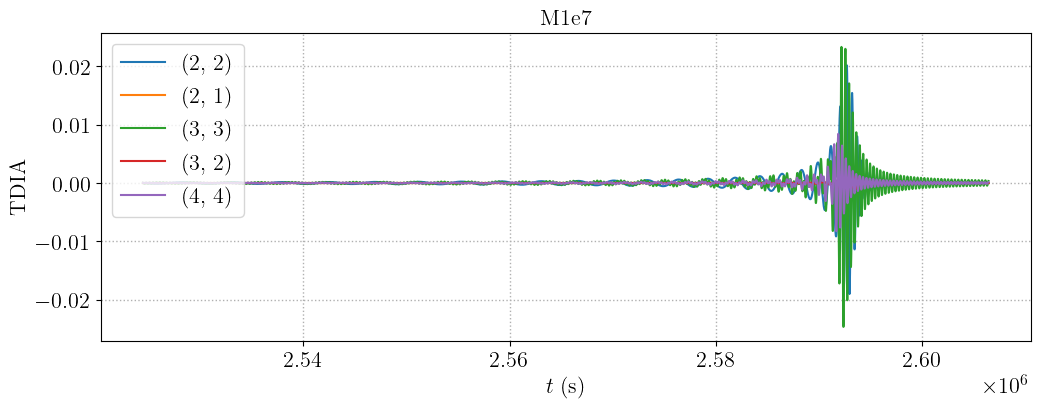

In [36]:
Mstr = '1e7'

fig, ax = plt.subplots(1,1, figsize=[12,4])
for lm in tdi_td['modes']:
    ax.plot(tdi_td[Mstr]['t'], tdi_td[Mstr][lm]['TDIA'], label=str(lm))
ax.set_xlabel(r'$t \; (\mathrm{s})$')
ax.set_ylabel(r'TDIA')
ax.set_title(r'M'+Mstr)
ax.legend(loc='upper left')

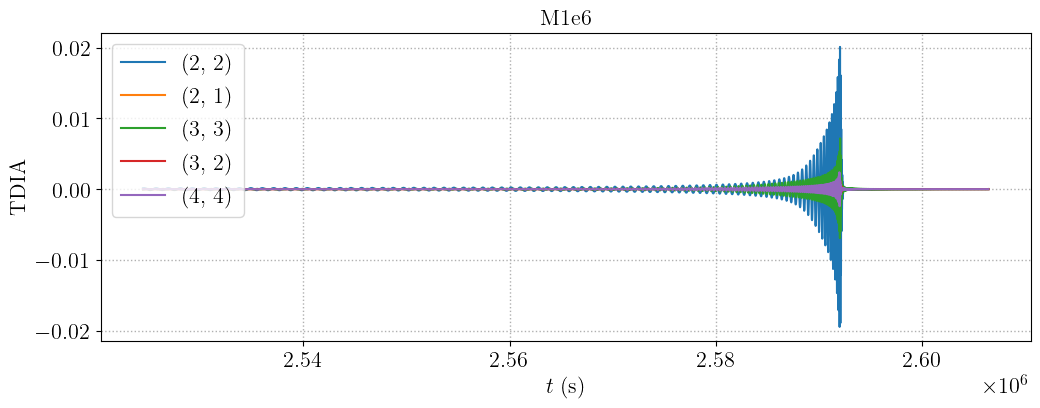

In [37]:
Mstr = '1e6'

fig, ax = plt.subplots(1,1, figsize=[12,4])
for lm in tdi_td['modes']:
    ax.plot(tdi_td[Mstr]['t'], tdi_td[Mstr][lm]['TDIA'], label=str(lm))
ax.set_xlabel(r'$t \; (\mathrm{s})$')
ax.set_ylabel(r'TDIA')
ax.set_title(r'M'+Mstr)
ax.legend(loc='upper left')

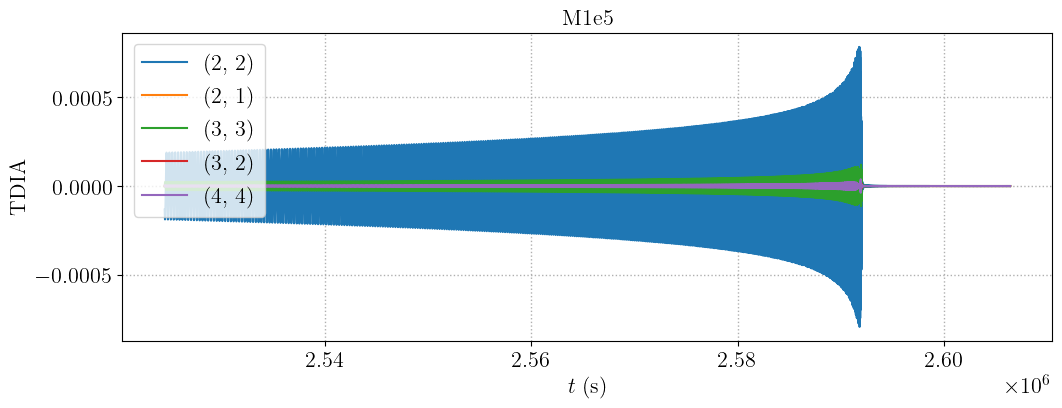

In [38]:
Mstr = '1e5'

fig, ax = plt.subplots(1,1, figsize=[12,4])
for lm in tdi_td['modes']:
    ax.plot(tdi_td[Mstr]['t'], tdi_td[Mstr][lm]['TDIA'], label=str(lm))
ax.set_xlabel(r'$t \; (\mathrm{s})$')
ax.set_ylabel(r'TDIA')
ax.set_title(r'M'+Mstr)
ax.legend(loc='upper left')

# Fisher sky localization

In [244]:
params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(1).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [160]:
# Parameters for the waveform generation and other options

waveform_params = {
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 2.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fstart22": None,
    "fend22": None,
    "tmin": None,
    "tmax": None,
    # TDI channels to generate
    "TDI": "TDIAET",
    # Internal accuracy params
    "order_fresnel": 0,
    # Waveform approximant and set of harmonics to use
    "approximant": "IMRPhenomXHM",
    "modes": None,
    # LISA response options
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

In [161]:
list_params = ['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']

# Use frequency grid adjusted to inspiral phasing at low frequencies, logarithmic at high frequencies, with default number of points
freqs = ['nyquist_log', None]

# Do the computation in the L-frame
Lframe = True

steps = lisa_fisher.get_default_steps_smbh(params['M'])

fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=freqs, steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)

In [107]:
lisatools.sky_area_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

14.660282964476014

In [121]:
lisatools.error_volume_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

7481.551405839143

## Variation with M

In [248]:
Mvals = np.geomspace(1e4, 1e8, 100)
zref = 1.

In [249]:
skyarea90_vals = np.zeros_like(Mvals)
for iM,M in enumerate(tqdm(Mvals)):
    params_M = copy.deepcopy(params)
    params_M['M'] = M
    params_M['dist'] = cosmo.luminosity_distance(zref).value
    fishercov = lisa_fisher.fisher_covariance_smbh(params_M, freqs=['log', 10000], steps=None, list_params=list_params, Lframe=Lframe, **waveform_params)
    skyarea90_vals[iM] = lisatools.sky_area_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.57it/s]


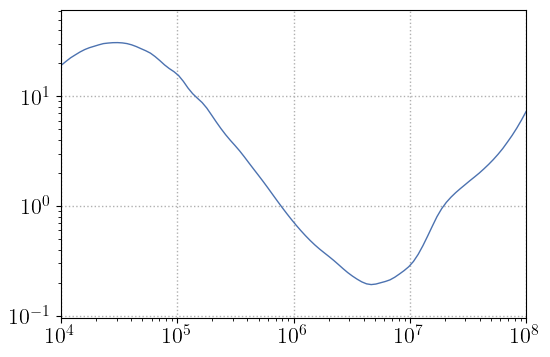

<Figure size 800x400 with 0 Axes>

In [250]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lloglogplot(ax, [Mvals, skyarea90_vals])

In [251]:
skyarea90_loglogspline_zref = pytools.spline(np.log(Mvals), np.log(skyarea90_vals))

def skyarea_interp(Msource, z):
    M = Msource * (1+z)
    if M > Mvals[-1] or M < Mvals[0]:
        return np.nan
    DLfactor = cosmo.luminosity_distance(z).value / cosmo.luminosity_distance(zref).value
    return np.exp(skyarea90_loglogspline_zref(np.log(M))) * DLfactor**2

In [277]:
zref = 1.

nb_z_mesh = 100
nb_Msource_mesh = 200
zvals = np.linspace(0.05, 10., nb_z_mesh)
Msourcevals = pytools.logspace(5e4, 5e7, nb_Msource_mesh)
Msource_mesh, z_mesh = np.meshgrid(Msourcevals, zvals)

In [278]:
skyarea_mesh = np.zeros((nb_z_mesh, nb_Msource_mesh))
for j in range(nb_Msource_mesh):
    for i in range(nb_z_mesh):
        Msource = Msource_mesh[i,j]
        z = z_mesh[i,j]
        skyarea_mesh[i,j] = skyarea_interp(Msource, z)

/tmp/ipykernel_42063/1076759815.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = ax.contourf(Msource_mesh, z_mesh, skyarea_mesh, levels, norm=mpl.colors.LogNorm(), extend='max', cmap=mpl.cm.get_cmap('viridis_r'))
/tmp/ipykernel_42063/1076759815.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


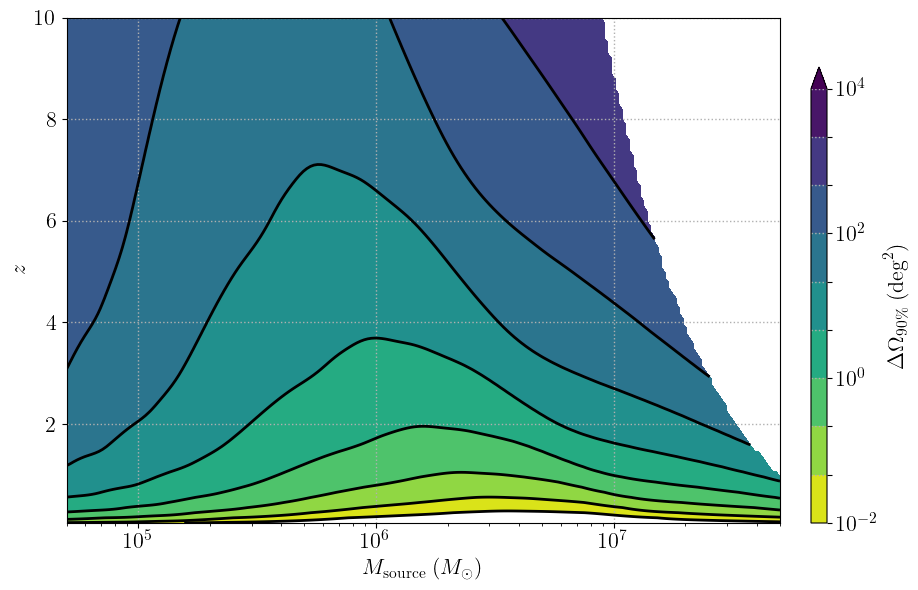

In [279]:
levels = 10**np.linspace(-2, 4, 10)

fig, ax = plt.subplots(1,1, figsize=[8,6])

cs = ax.contourf(Msource_mesh, z_mesh, skyarea_mesh, levels, norm=mpl.colors.LogNorm(), extend='max', cmap=mpl.cm.get_cmap('viridis_r'))
ax.contour(Msource_mesh, z_mesh, skyarea_mesh, levels, colors='k', linewidths=2)
cb_ax = fig.add_axes([1.02, 0.12, 0.02, 0.76]) # left, bottom, width, height
cbar = fig.colorbar(cs, cax=cb_ax, ticks=levels)
cbar.ax.set_ylabel(r'$\Delta \Omega_{90\%} \; (\mathrm{deg}^2)$', fontsize=16)
#cbar.ax.set_yticklabels([r'$10$', r'$20$', r'$50$', r'$200$', r'$500$', r'$1000$', r'$3000$'], fontsize=16)
plt.subplots_adjust(wspace=0.15)
# manual_locations = [(3e3, 15), (5e3, 17), (1.5e4, 10), (7e4, 4), (2e5, 3), (4e5, 2.5), (5e5, 1.5)]
# ax.clabel(cs, inline=1, fontsize=16, fmt='%3.0f', manual=manual_locations)
ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm source} \; (M_{\odot})$')
ax.set_ylabel(r'$z$')
#ax.set_title(r'' + tcut)
    
fig.tight_layout()

#fig.savefig('plots/snr_av_tcut.pdf', bbox_inches='tight')

## Trend in (inc, betaL)

In [167]:
fishercov_fast = lisa_fisher.fisher_covariance_smbh(params, freqs=['log', 10000], steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)

In [168]:
%time fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=freqs, steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)
%time fishercov_fast = lisa_fisher.fisher_covariance_smbh(params, freqs=['log', 10000], steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)

CPU times: user 911 ms, sys: 98.2 ms, total: 1.01 s
Wall time: 1.02 s
CPU times: user 88.3 ms, sys: 13.1 ms, total: 101 ms
Wall time: 105 ms


In [169]:
nb_inc_mesh = 10
nb_betaL_mesh = 10
eps = 1e-3
incvals = np.linspace(0. + eps, np.pi - eps, nb_inc_mesh)
betaLvals = np.linspace(-np.pi/2 + eps, np.pi/2 - eps, nb_betaL_mesh)
inc_mesh, betaL_mesh = np.meshgrid(incvals, betaLvals)

### High-mass

In [273]:
params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(1.).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [274]:
snr_mesh = np.zeros((nb_betaL_mesh, nb_inc_mesh))
skyarea90_mesh = np.zeros((nb_betaL_mesh, nb_inc_mesh))
sigma_dL_rel_mesh = np.zeros((nb_betaL_mesh, nb_inc_mesh))
for j in tqdm(range(nb_inc_mesh)):
    for i in range(nb_betaL_mesh):
        inc = inc_mesh[i,j]
        betaL = betaL_mesh[i,j]
        params_temp = params.copy()
        params_temp['inc'] = inc
        params_temp['beta'] = betaL
        tdisignal = lisa.GenerateLISATDISignal_SMBH(params_temp, **waveform_params)
        snr = tdisignal['SNR']
        fishercov = lisa_fisher.fisher_covariance_smbh(params_temp, freqs=['log', 10000], Lframe=True, **waveform_params)
        idist = fishercov['list_params'].index('dist')
        sigma_dL_rel = np.sqrt(fishercov['cov'][idist,idist]) / params['dist']
        skyarea90 = lisatools.sky_area_cov(fishercov, sq_deg=True, prob=0.90)
        snr_mesh[i,j] = snr
        skyarea90_mesh[i,j] = skyarea90
        sigma_dL_rel_mesh[i,j] = sigma_dL_rel

100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


In [182]:
np.min(snr_mesh), np.max(snr_mesh)

(2538.2773344278635, 18051.57867787921)

/tmp/ipykernel_42063/2500561877.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = ax.contourf(inc_mesh, betaL_mesh, snr_mesh, levels_snr, extend='both', cmap=mpl.cm.get_cmap('viridis'))
/tmp/ipykernel_42063/2500561877.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


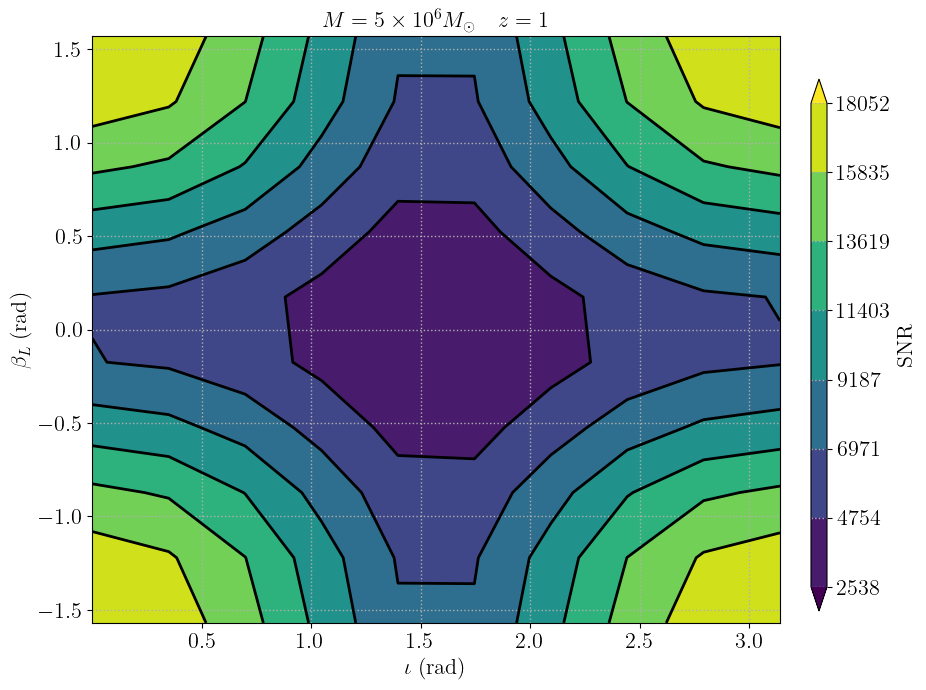

In [275]:
levels_snr = np.linspace(np.min(snr_mesh), np.max(snr_mesh), 8)

fig, ax = plt.subplots(1,1, figsize=[8,7])

cs = ax.contourf(inc_mesh, betaL_mesh, snr_mesh, levels_snr, extend='both', cmap=mpl.cm.get_cmap('viridis'))
ax.contour(inc_mesh, betaL_mesh, snr_mesh, levels_snr, colors='k', linewidths=2)
cb_ax = fig.add_axes([1.02, 0.12, 0.02, 0.76]) # left, bottom, width, height
cbar = fig.colorbar(cs, cax=cb_ax, ticks=levels_snr)
cbar.ax.set_ylabel(r'$\mathrm{SNR}$', fontsize=16)
#cbar.ax.set_yticklabels([r'$10$', r'$20$', r'$50$', r'$200$', r'$500$', r'$1000$', r'$3000$'], fontsize=16)
plt.subplots_adjust(wspace=0.15)
# manual_locations = [(3e3, 15), (5e3, 17), (1.5e4, 10), (7e4, 4), (2e5, 3), (4e5, 2.5), (5e5, 1.5)]
# ax.clabel(cs, inline=1, fontsize=16, fmt='%3.0f', manual=manual_locations)
ax.set_xlabel(r'$\iota \; (\mathrm{rad})$')
ax.set_ylabel(r'$\beta_L \; (\mathrm{rad})$')
ax.set_title(r'$M=5\times 10^6 M_\odot \quad z=1$')

fig.tight_layout()

In [185]:
np.min(skyarea90_mesh), np.max(skyarea90_mesh)

(0.0004106701656635856, 13.663633418686677)

/tmp/ipykernel_42063/1532972262.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = ax.contourf(inc_mesh, betaL_mesh, skyarea90_mesh, levels_skyarea, norm=mpl.colors.LogNorm(), extend='both', cmap=mpl.cm.get_cmap('viridis_r'))
/tmp/ipykernel_42063/1532972262.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


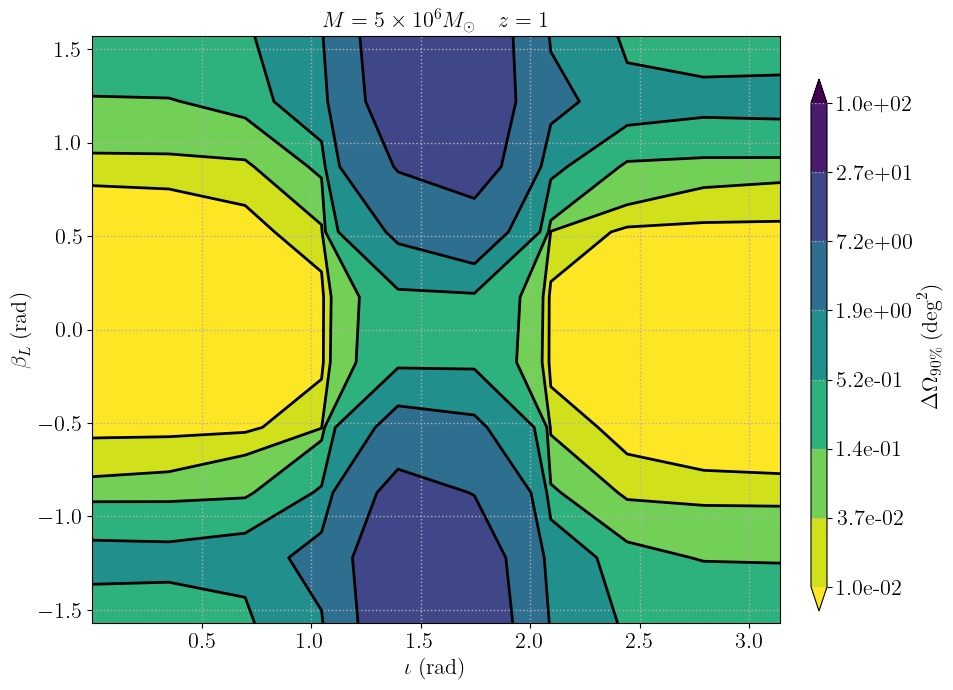

In [276]:
levels_skyarea = np.geomspace(1e-2, 100., 8)

fig, ax = plt.subplots(1,1, figsize=[8,7])

cs = ax.contourf(inc_mesh, betaL_mesh, skyarea90_mesh, levels_skyarea, norm=mpl.colors.LogNorm(), extend='both', cmap=mpl.cm.get_cmap('viridis_r'))
ax.contour(inc_mesh, betaL_mesh, skyarea90_mesh, levels_skyarea, colors='k', linewidths=2)
cb_ax = fig.add_axes([1.02, 0.12, 0.02, 0.76]) # left, bottom, width, height
cbar = fig.colorbar(cs, cax=cb_ax, ticks=levels_skyarea, format='%.1e')
cbar.ax.set_ylabel(r'$\Delta\Omega_{90\%} \; (\mathrm{deg}^2)$', fontsize=16)
#cbar.ax.set_yticklabels([r'$10$', r'$20$', r'$50$', r'$200$', r'$500$', r'$1000$', r'$3000$'], fontsize=16)
plt.subplots_adjust(wspace=0.15)
# manual_locations = [(3e3, 15), (5e3, 17), (1.5e4, 10), (7e4, 4), (2e5, 3), (4e5, 2.5), (5e5, 1.5)]
# ax.clabel(cs, inline=1, fontsize=16, fmt='%3.0f', manual=manual_locations)
ax.set_xlabel(r'$\iota \; (\mathrm{rad})$')
ax.set_ylabel(r'$\beta_L \; (\mathrm{rad})$')
ax.set_title(r'$M=5\times 10^6 M_\odot \quad z=1$')

fig.tight_layout()

# Sky multimodality: a simple measure

In [110]:
skymodes = [(1,0), (-1,0), (1,1), (-1,1), (1,2), (-1,2), (1,3), (-1,3)]

In [108]:
likelihood = lisa.LikelihoodLISASMBH(params, **waveform_params)

In [109]:
lisatools.func_loglikelihood_skymodes(likelihood)

{(1, 0): -2.3283064365386963e-10,
 (-1, 0): -1.2197428061626852,
 (1, 1): -533.7968161312165,
 (-1, 1): -534.3391834110953,
 (1, 2): -1061.9610051735071,
 (-1, 2): -1059.7861311220913,
 (1, 3): -534.4395742332563,
 (-1, 3): -534.9276103643933}

In [119]:
maxf_vals = np.geomspace(1e-4, 1e-2, 100)

snr_vals = np.zeros_like(maxf_vals)
lnL_skymodes_vals = {}
for skymode in skymodes:
    lnL_skymodes_vals[skymode] = np.zeros_like(maxf_vals)
for i,maxf in enumerate(tqdm(maxf_vals)):
    waveform_params_maxf = copy.deepcopy(waveform_params)
    waveform_params_maxf['maxf'] = maxf
    likelihood = lisa.LikelihoodLISASMBH(params, **waveform_params_maxf)
    snr_vals[i] = likelihood.tdisignal_inj['SNR']
    lnL_skymodes = lisatools.func_loglikelihood_skymodes(likelihood)
    for skymode in skymodes:
        lnL_skymodes_vals[skymode][i] = lnL_skymodes[skymode]

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.24it/s]


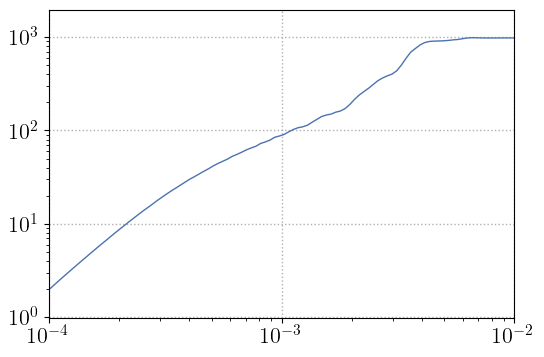

<Figure size 800x400 with 0 Axes>

In [120]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lloglogplot(ax, [maxf_vals, snr_vals])

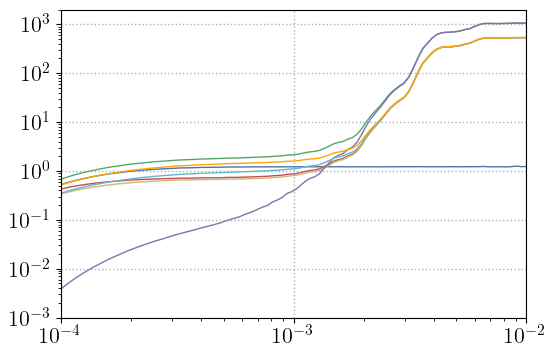

<Figure size 800x400 with 0 Axes>

In [117]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lloglogplot(ax, *[[maxf_vals, -lnL_skymodes_vals[skymode]] for skymode in skymodes[1:]], rangey=[1e-3, 2e3])

# Multimodality: Bayesian parameter estimation

## Setting parameters

In [4]:
# Redshift z=4
cosmo.luminosity_distance(6.).value

59046.10457286159

In [5]:
# Physical signal parameters

z = 6.

params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(z).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [6]:
# Parameters for the waveform generation and other options

waveform_params = {
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 2.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fstart22": None,
    "fend22": None,
    "tmin": None,
    "tmax": None,
    # TDI channels to generate
    "TDI": "TDIAET",
    # Internal accuracy params
    "order_fresnel": 0,
    # Waveform approximant and set of harmonics to use
    "approximant": "IMRPhenomXHM",
    "modes": None,
    # LISA response options
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

## PE results

In [22]:
subsdir = '/Users/marsat/Projects/tutorials/lisabeta_sky_tutorial/lisabeta_sky_tutorial/example_pe/'
datadir = '/Users/marsat/Projects/tutorials/lisabeta_sky_tutorial/lisabeta_sky_tutorial/example_pe/'

In [23]:
subfile = subsdir + 'mbhb_pe_example.json'
postfile = datadir + 'mbhb_pe_example.h5'

params_post = plotutils.load_params_posterior_lisa_smbh(subfile, postfile)

post_raw_file = datadir + 'mbhb_pe_example_raw.h5'

post_raw = {}
with h5py.File(post_raw_file, 'r') as hf:
    for p in params_post['prior_params']['infer_params']:
        post_raw[p] = hf[p][:]
    post_raw['lnL'] = hf['lnlike'][:]

In [24]:
params_post.keys()

dict_keys(['fishercov', 'injparams_SSBframe', 'injparams_Lframe', 'waveform_params', 'prior_params', 'run_params', 'post'])

In [25]:
params_post['prior_params']['infer_params']

['Mchirp',
 'q',
 'chip',
 'chim',
 'Deltat',
 'dist',
 'inc',
 'phi',
 'lambda',
 'beta',
 'psi']

In [26]:
params_post['post'].keys()

dict_keys(['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi', 'lnL', 'lnpost', 'Lframe', 'm1', 'm2', 'M', 'eta', 'chi1', 'chi2', 'chis', 'chia', 'chiPN'])

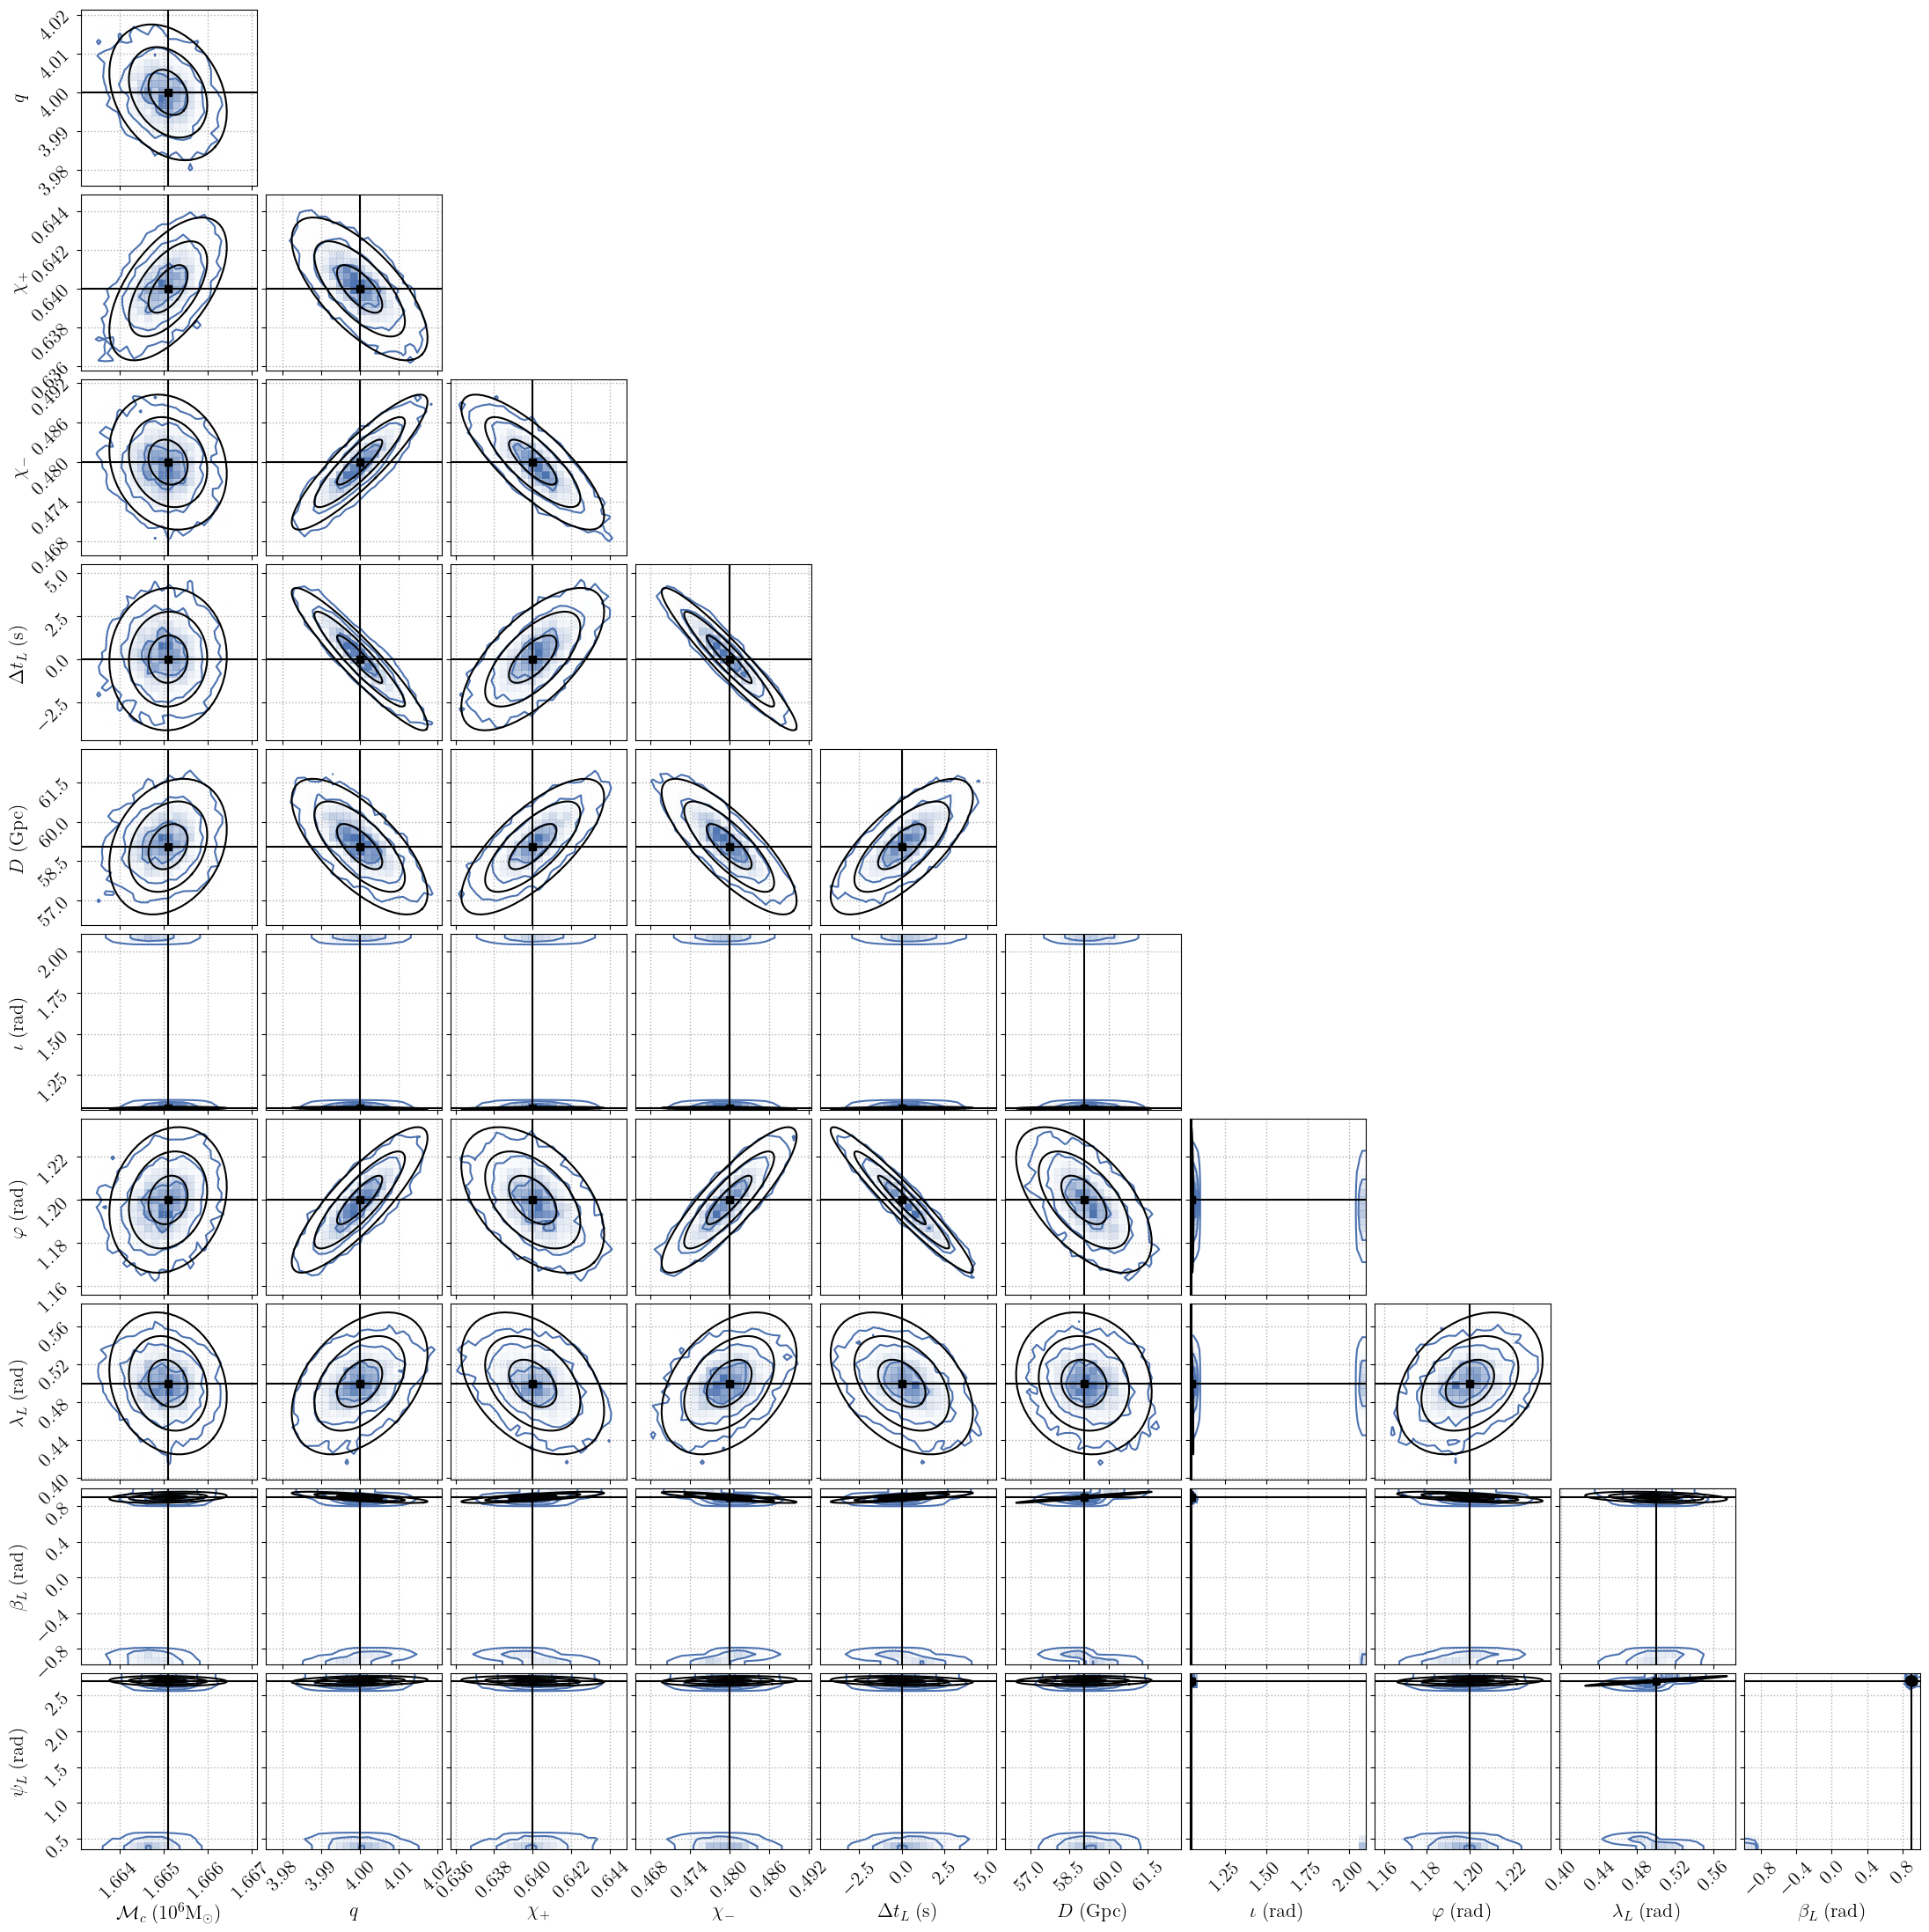

In [27]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], params_post['post'], output=False, histograms=True, fisher=True, fishercov=params_post['fishercov'], params=['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi'], Lframe=True, color=plotutils.plotpalette[0], cov_color='k', show_truths=True, truth_color='k', bins=25, show_histograms=False, plot_datapoints=False);

In [28]:
Nsamples = params_post['post']['beta'].shape[0]
np.sum(params_post['post']['beta'] > 0) / Nsamples, np.sum(params_post['post']['beta'] < 0) / Nsamples

(0.626578125, 0.373421875)

## A closer look at the multimodal posterior

In [41]:
mask_main = (params_post['post']['beta'] > 0)
post_main = {}
for p in list_params:
     post_main[p] = params_post['post'][p][mask_main]
post_main['lnL'] = params_post['post']['lnL'][mask_main]
post_main['Lframe'] = params_post['post']['Lframe']
post_main = pytools.complete_all_params(post_main)

mask_reflected = (params_post['post']['beta'] < 0)
post_reflected = {}
for p in list_params:
     post_reflected[p] = params_post['post'][p][mask_reflected]
post_reflected['lnL'] = params_post['post']['lnL'][mask_reflected]
post_reflected['Lframe'] = params_post['post']['Lframe']
post_reflected = pytools.complete_all_params(post_reflected)

imax_reflected = np.argmax(params_post['post']['lnL'][mask_reflected])
params_reflected_maxlnL = {}
for p in list_params:
     params_reflected_maxlnL[p] = post_reflected[p][imax_reflected]
params_reflected_maxlnL['Lframe'] = params_post['post']['Lframe']
params_reflected_maxlnL = pytools.complete_all_params(params_reflected_maxlnL)

post_reflected_plt = jump_params_skymode(post_reflected, (-1,0))
params_reflected_maxlnL_plt = jump_params_skymode(params_reflected_maxlnL, (-1,0))

In [42]:
params_reflected_maxlnL_plt = jump_params_skymode(params_reflected_maxlnL, (-1,0))

In [43]:
post_reflected_plt = jump_params_skymode(post_reflected, (-1,0))

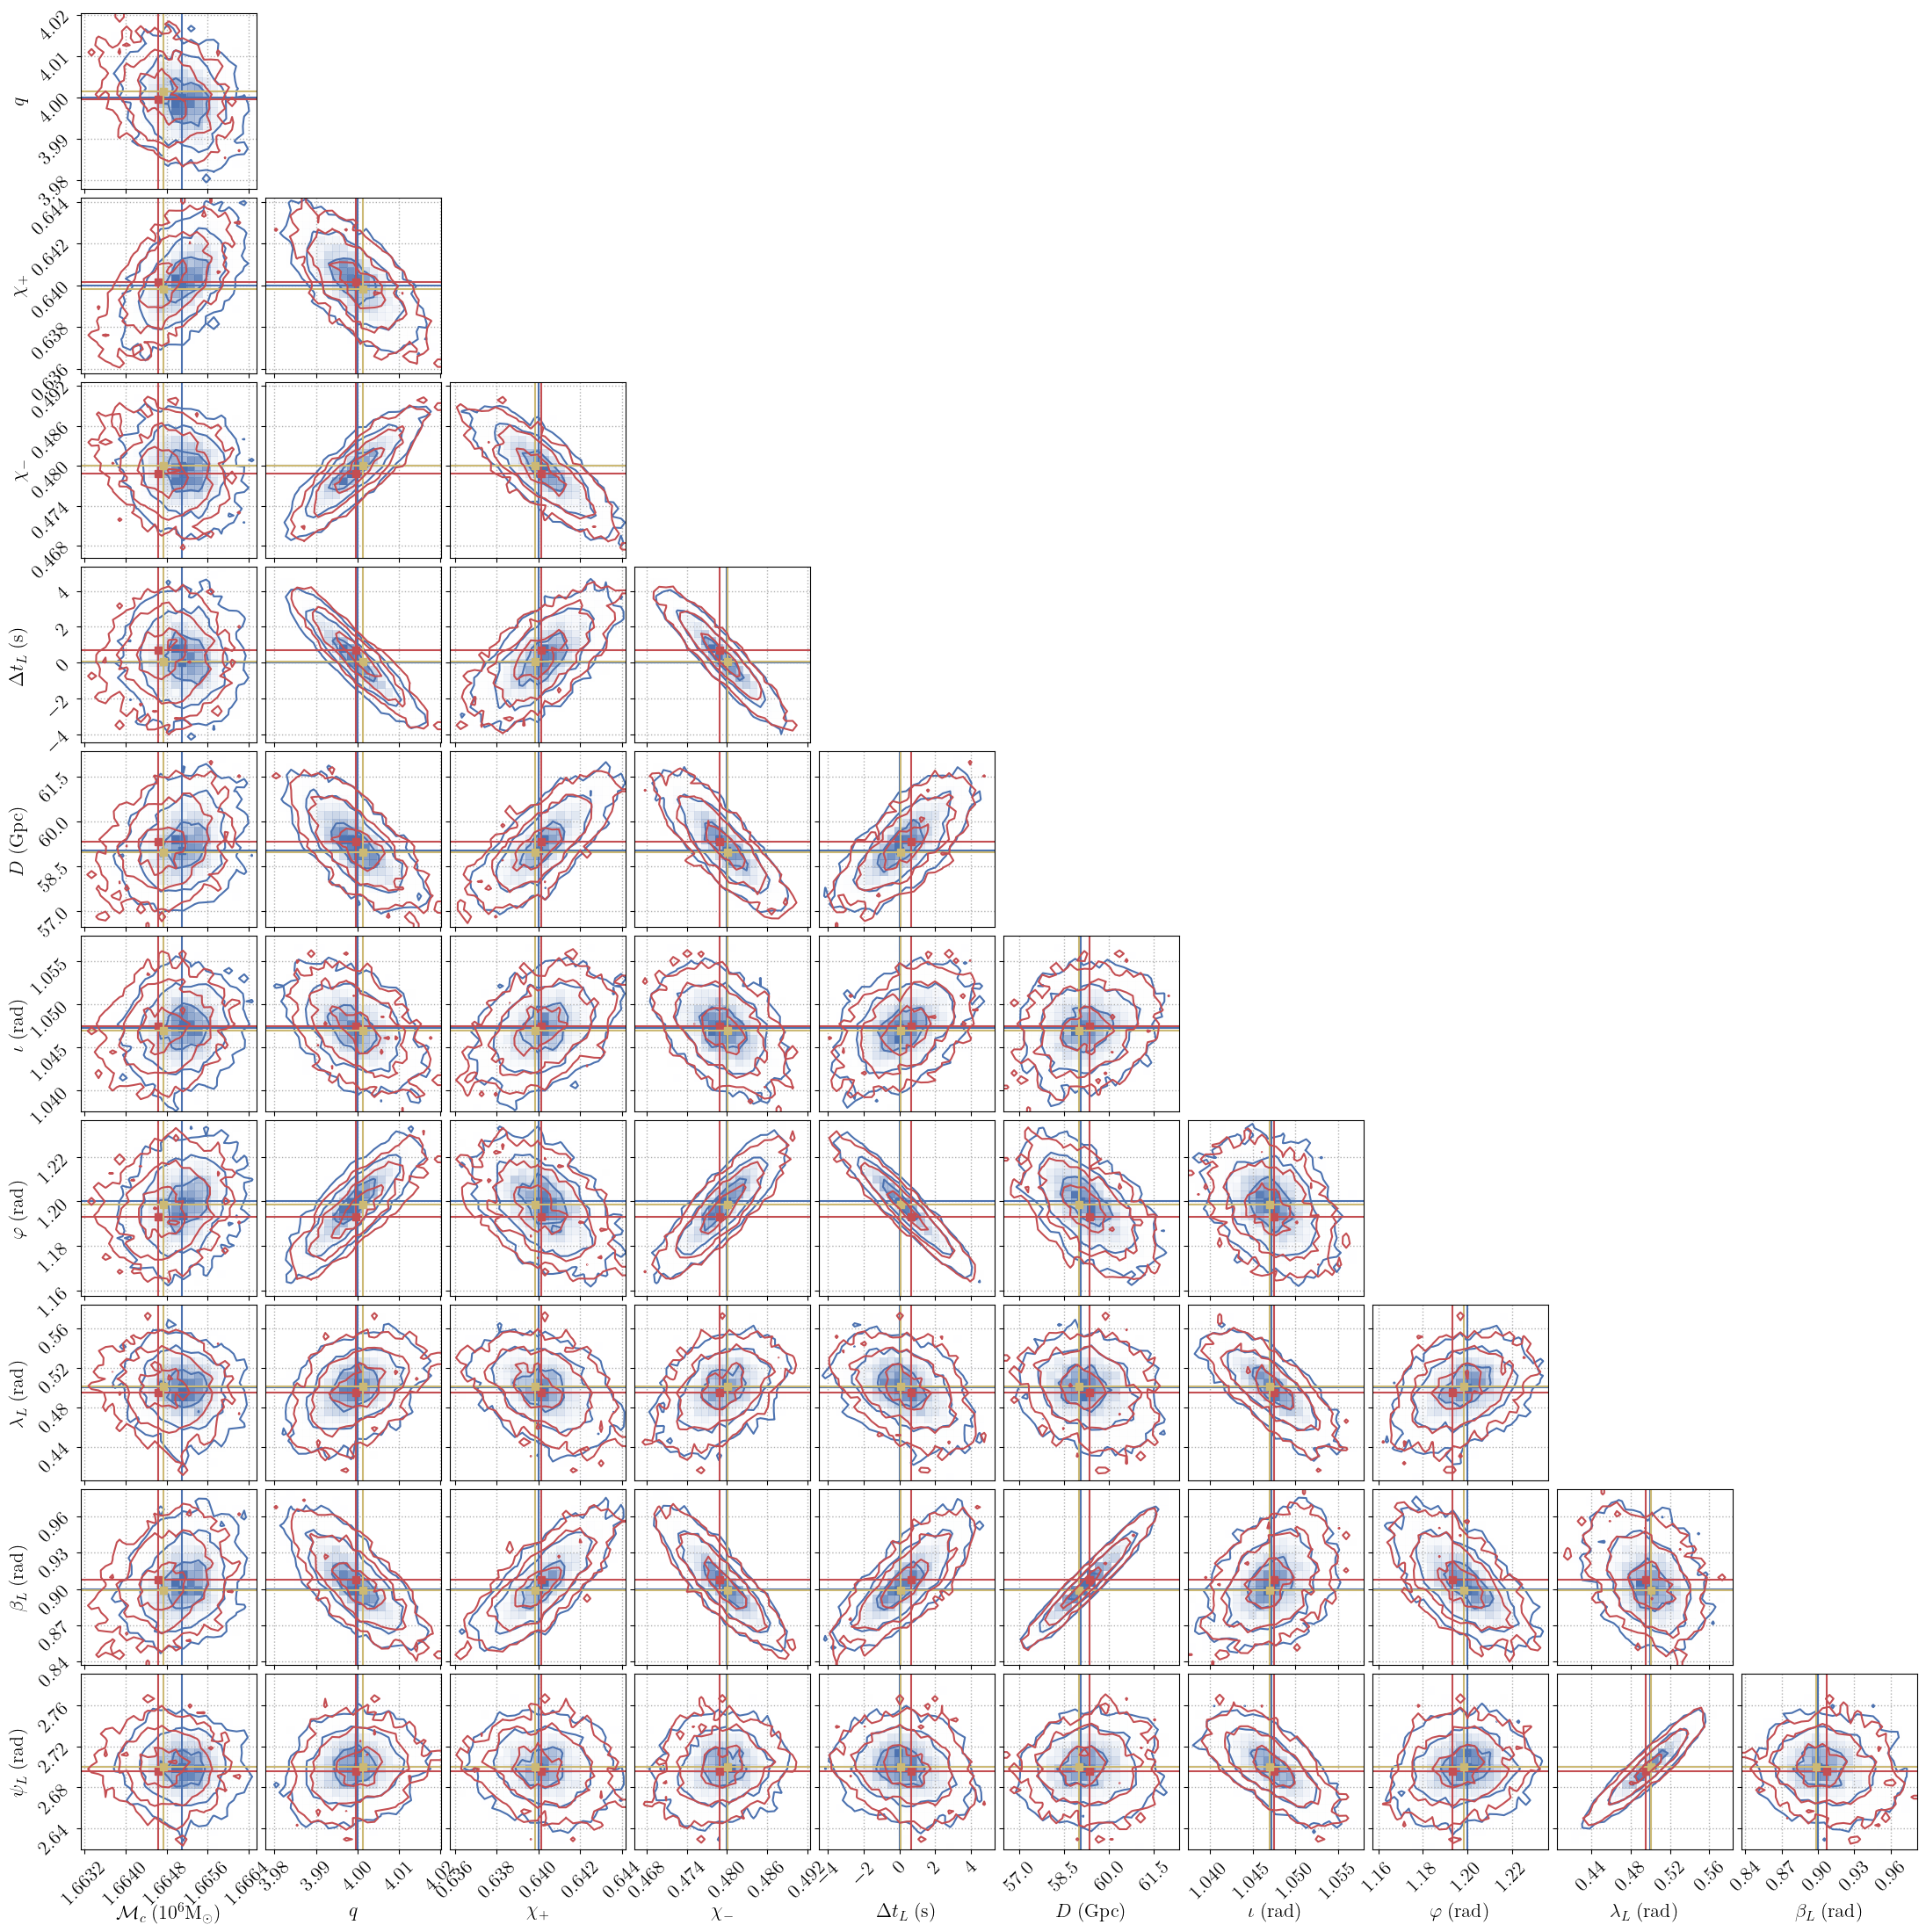

In [82]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], post_main, output=False, histograms=True, fisher=False, fishercov=None, add_posteriors=[post_reflected_plt], add_truths=[params_reflected_maxlnL_plt], params=list_params, Lframe=True, color=plotutils.plotpalette[0], add_colors=[plotutils.plotpalette[1]], add_truth_colors=[plotutils.plotpalette[1]], cov_color='k', show_truths=True, truth_color=plotutils.plotpalette[0], bins=25, show_histograms=False, plot_datapoints=False);

## Sky modes: going beyond the simple lnL estimate

In [7]:
likelihood = lisa.LikelihoodLISASMBH_LinearResiduals(params,
                                            ref_params=None,
                                            ngrid=128,
                                            data=None, **waveform_params)

In [8]:
lisatools.func_loglikelihood_skymodes(likelihood)

{(1, 0): -4.596185747453702e-27,
 (-1, 0): -1.2194311058899083,
 (1, 1): -526.3235368015313,
 (-1, 1): -526.8530137767534,
 (1, 2): -1047.0896516987298,
 (-1, 2): -1044.921613125887,
 (1, 3): -526.9693989338863,
 (-1, 3): -527.4614198251502}

In [62]:
list_params = ['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']

fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=['nyquist_log', None], list_params=list_params, Lframe=True, **waveform_params)

In [63]:
params_complete = pytools.complete_all_params(params)
scales = np.array([np.sqrt(fishercov['cov'][ip,ip]) for ip,p in enumerate(list_params)])

def pars_from_x(x, ref_params=params_complete):
    pars = dict([(p, ref_params[p] + scales[ip] * x[ip]) for ip,p in enumerate(list_params)]) 
    pars['Lframe'] = True
    return pars

def x_from_pars(pars, ref_params=params_complete):
    return np.array([(pars[p] - ref_params[p]) / scales[ip] for ip,p in enumerate(list_params)])

# This is the function that will be minimized by the Nelder-Mead algorithm.
def f_het(x, ref_params):
    pars = pars_from_x(x, ref_params=ref_params)
    return -likelihood.lnL(pars)

In [64]:
x_inj = x_from_pars(params_complete)

In [77]:
dim = 11
initial_simplex_size = 20

initial_simplex = np.zeros((dim+1,dim), dtype=float)
for i in range(1,dim+1):
    initial_simplex[i,i-1] = initial_simplex_size
    
res_neldermead_inj = scipy.optimize.minimize(f_het, x_inj, params_complete, method='Nelder-Mead', options={'initial_simplex': initial_simplex, 'return_all': True, 'maxiter':20000, 'maxfev':20000})
res_neldermead_inj

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5.426157748265654e-06
             x: [-5.989e-05 -2.483e-04 -6.886e-04  1.695e-04 -1.982e-04
                 -8.624e-04  6.116e-04 -2.319e-04 -3.119e-04 -6.402e-04
                 -5.678e-04]
           nit: 291
          nfev: 537
 final_simplex: (array([[-5.989e-05, -2.483e-04, ..., -6.402e-04,
                        -5.678e-04],
                       [-6.342e-05, -2.452e-04, ..., -6.669e-04,
                        -5.769e-04],
                       ...,
                       [-8.672e-06, -2.208e-04, ..., -6.119e-04,
                        -5.673e-04],
                       [-4.353e-05, -2.427e-04, ..., -6.328e-04,
                        -5.724e-04]]), array([ 5.426e-06,  6.527e-06,  8.075e-06,  1.672e-05,
                        1.756e-05,  2.811e-05,  4.096e-05,  4.522e-05,
                        4.977e-05,  7.669e-05,  7.745e-05,  9.653e-05]))
       allvecs: [a

In [66]:
def jump_params_skymode(params, skymode):
    if not params.get('Lframe', 'False'):
        raise ValueError('Requires parameters in the L-frame.')
    params_skymode = copy.deepcopy(params)
    skymode_index0, skymode_index1 = skymode
    inc = params['inc']
    lambdaL = params['lambda']
    betaL = params['beta']
    psiL = params['psi']
    params_skymode['inc'] = pytools.modpi(np.pi/2 - (skymode_index0 *(np.pi/2 - inc)))
    params_skymode['lambda'] = pytools.mod2pi(lambdaL + skymode_index1 * np.pi/2)
    params_skymode['beta'] = skymode_index0 * betaL
    params_skymode['psi'] = pytools.modpi(np.pi/2 - (skymode_index0 *(np.pi/2 - psiL)) + skymode_index1 * np.pi/2)
    return params_skymode

In [67]:
params_reflected = jump_params_skymode(params_complete, (-1,0))

In [68]:
x_reflected = x_from_pars(params_reflected, ref_params=params_reflected)

In [69]:
x_reflected

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
dim = 11
initial_simplex_size = 20

initial_simplex = np.zeros((dim+1,dim), dtype=float)
for i in range(1,dim+1):
    initial_simplex[i,i-1] = initial_simplex_size

res_neldermead_reflected = scipy.optimize.minimize(f_het, x_reflected, params_reflected,  method='Nelder-Mead', options={'initial_simplex': initial_simplex, 'return_all': True, 'maxiter':20000, 'maxfev':20000})
res_neldermead_reflected

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.6346602973933761
             x: [-9.154e-01  2.419e-01 -1.388e-01  2.302e-02  4.604e-02
                 -6.817e-02  6.595e-02 -1.379e-01  4.466e-02  6.257e-02
                 -2.289e-02]
           nit: 584
          nfev: 1231
 final_simplex: (array([[-9.154e-01,  2.419e-01, ...,  6.257e-02,
                        -2.289e-02],
                       [-9.154e-01,  2.419e-01, ...,  6.257e-02,
                        -2.289e-02],
                       ...,
                       [-9.154e-01,  2.419e-01, ...,  6.257e-02,
                        -2.289e-02],
                       [-9.154e-01,  2.419e-01, ...,  6.257e-02,
                        -2.289e-02]]), array([ 6.347e-01,  6.347e-01,  6.347e-01,  6.347e-01,
                        6.347e-01,  6.347e-01,  6.347e-01,  6.347e-01,
                        6.347e-01,  6.347e-01,  6.347e-01,  6.347e-01]))
       allvecs: [arr

In [79]:
params_reflected, pars_from_x(res_neldermead_reflected.x, ref_params=params_reflected)

({'M': 5000000.0,
  'q': 4.0,
  'chi1': 0.7,
  'chi2': 0.4,
  'Deltat': 0.0,
  'dist': 59046.10457286159,
  'inc': 2.0943951023931957,
  'phi': 1.2,
  'lambda': 0.5,
  'beta': -0.9,
  'psi': 0.44159265358979294,
  'Lframe': True,
  'm1': 4000000.0,
  'm2': 1000000.0,
  'Mchirp': 1665106.4148037464,
  'eta': 0.16,
  'chis': 0.55,
  'chia': 0.14999999999999997,
  'chip': 0.6399999999999999,
  'chim': 0.4799999999999999,
  'chiPN': 0.5808141592920354,
  'chi1x': 0.0,
  'chi1y': 0.0,
  'chi1z': 0.7,
  'chi2x': 0.0,
  'chi2y': 0.0,
  'chi2z': 0.4},
 {'Mchirp': 1664736.911937852,
  'q': 4.001405860870854,
  'chip': 0.6398321083307763,
  'chim': 0.4800784636536002,
  'Deltat': 0.0637156409636178,
  'dist': 58987.2189848846,
  'inc': 2.094609058998301,
  'phi': 1.1984503135522744,
  'lambda': 0.5011129179893627,
  'beta': -0.8986912721473181,
  'psi': 0.4410656616751614,
  'Lframe': True})

In [81]:
params_reflected_NM = pars_from_x(res_neldermead_reflected.x, ref_params=params_reflected)
params_reflected_NM = pytools.complete_all_params(params_reflected_NM_plt)

params_reflected_NM_plt = jump_params_skymode(params_reflected_NM, (-1,0))

In [157]:
(params_reflected_NM_plt['Mchirp'] - params_complete['Mchirp']) / params_complete['Mchirp']

-0.00022190946032600283

In [158]:
(2*np.pi*pyconstants.AU_SI / pyconstants.YRSID_SI / pyconstants.C_SI)

9.935118343450704e-05

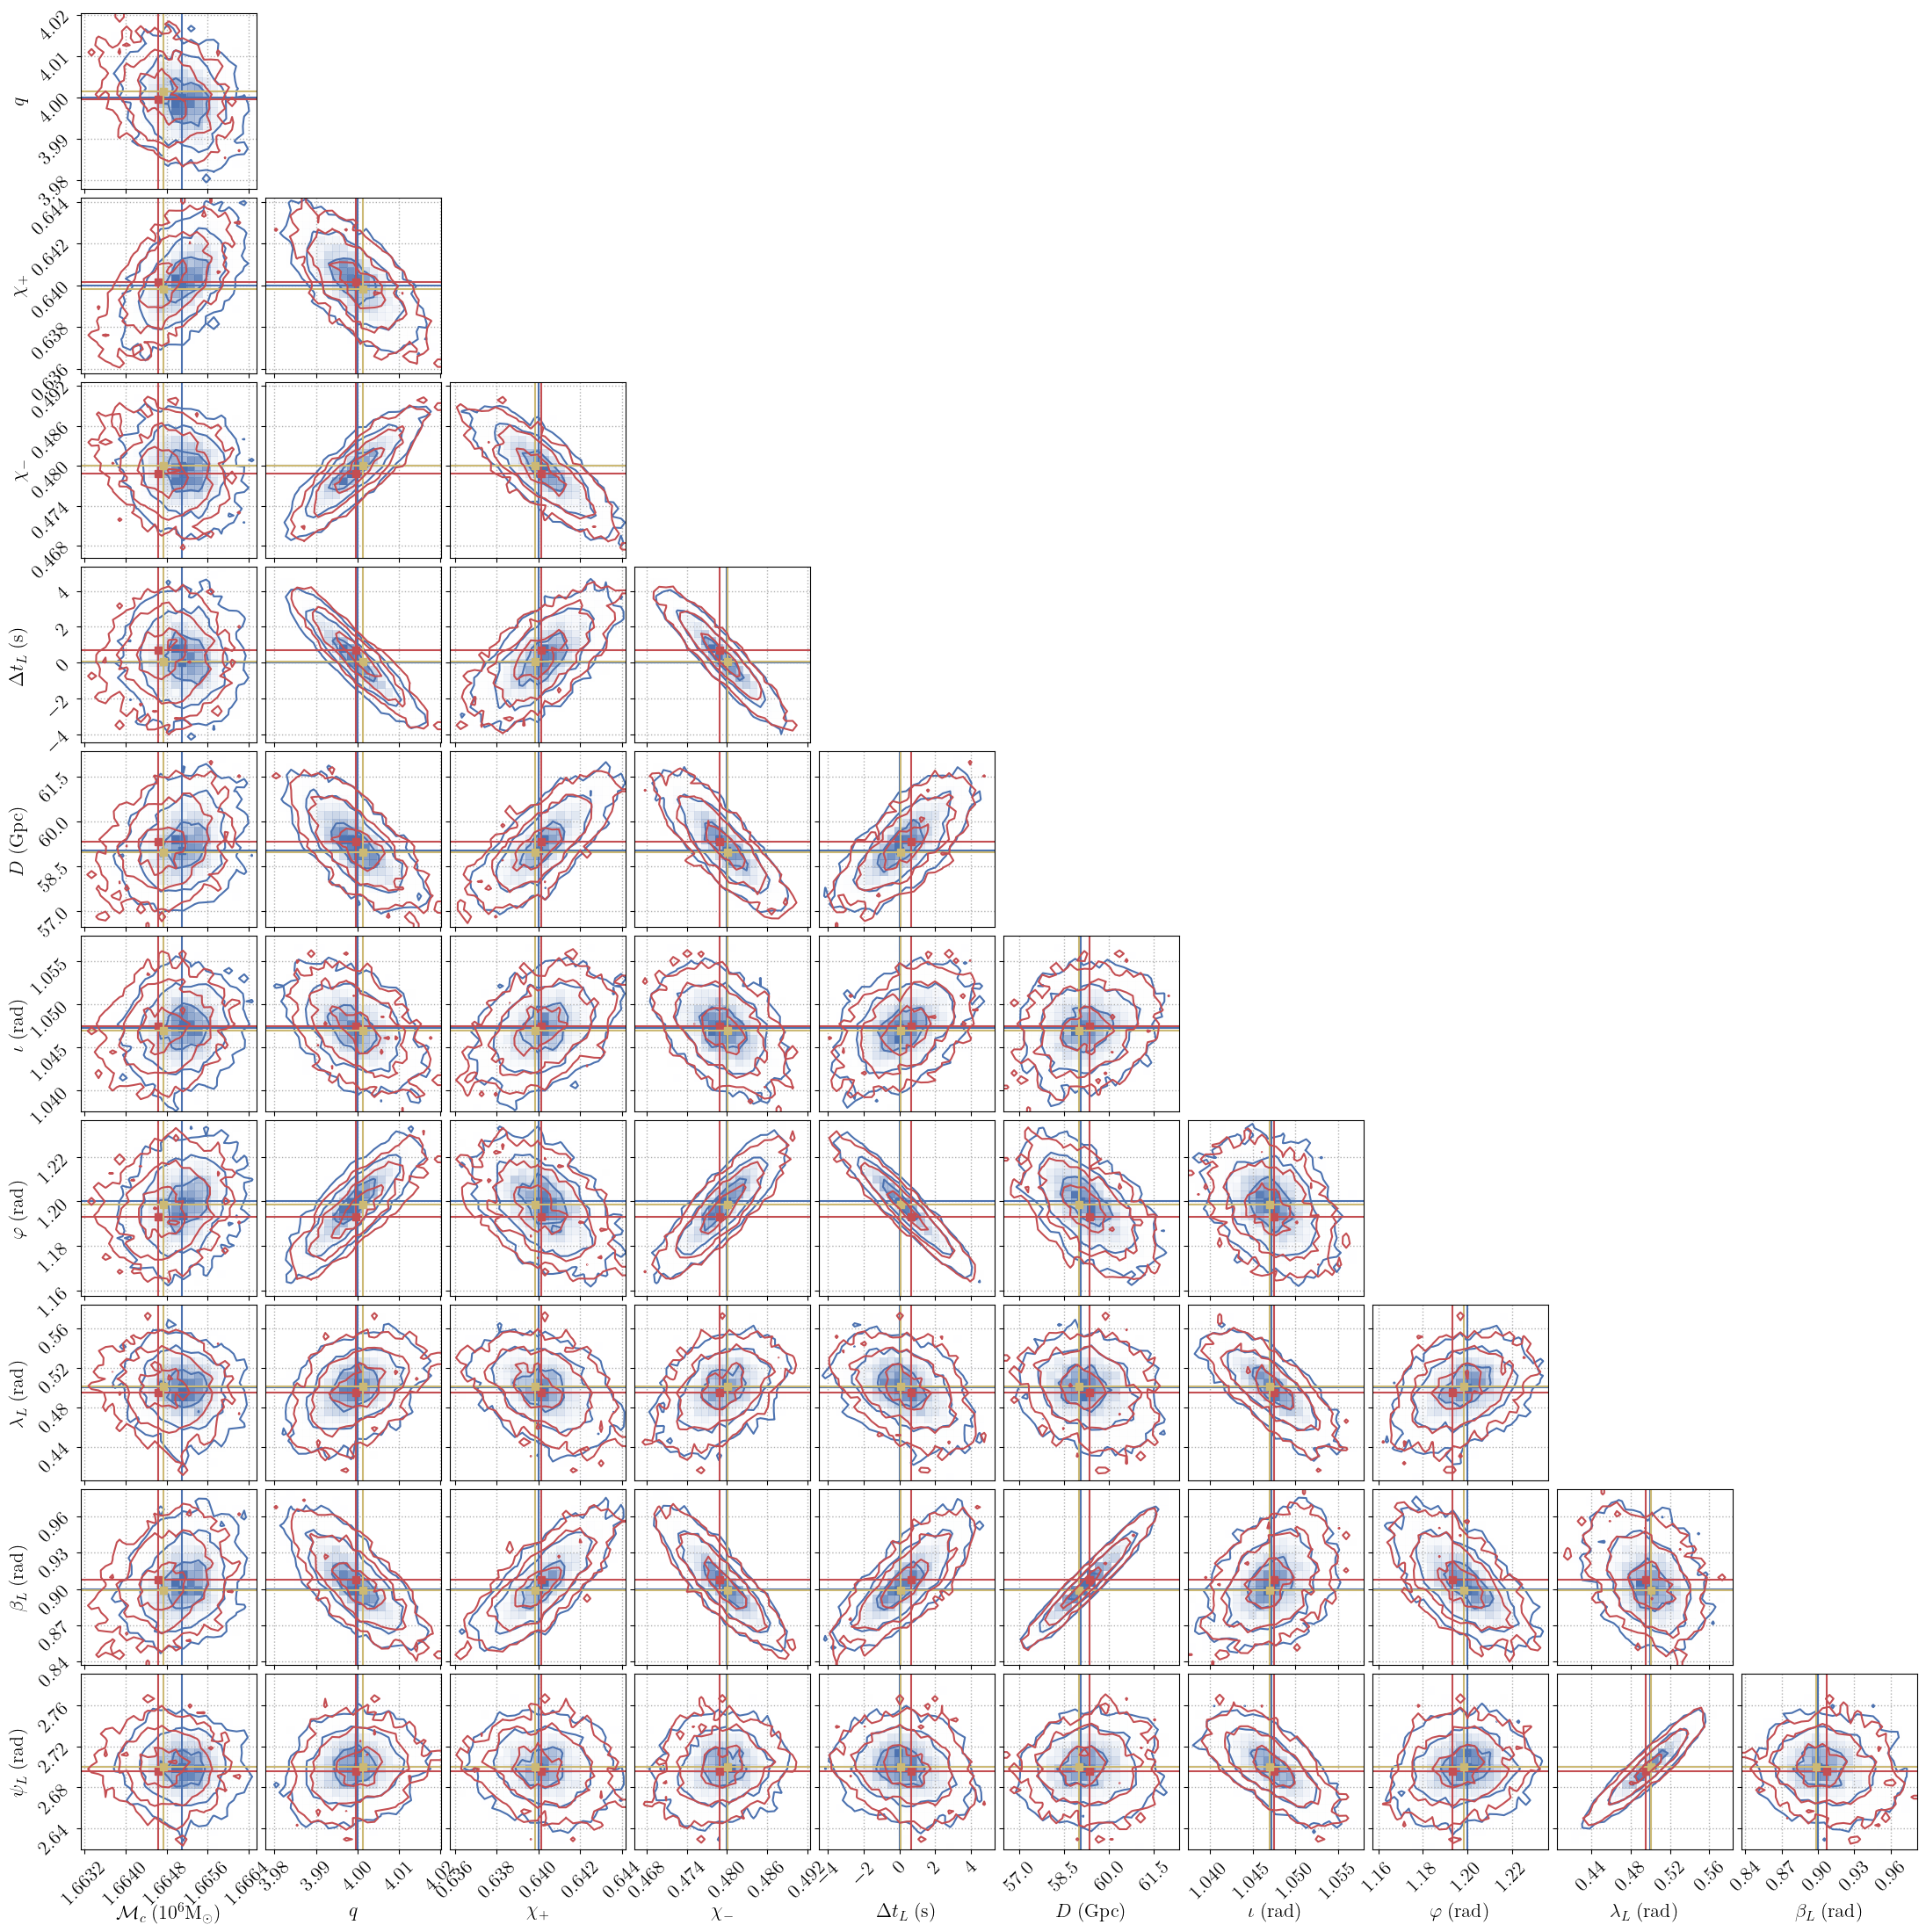

In [82]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], post_main, output=False, histograms=True, fisher=False, fishercov=None, add_posteriors=[post_reflected_plt], add_truths=[params_reflected_maxlnL_plt, params_reflected_NM_plt], params=list_params, Lframe=True, color=plotutils.plotpalette[0], add_colors=[plotutils.plotpalette[1]], add_truth_colors=[plotutils.plotpalette[1], plotutils.plotpalette[2]], cov_color='k', show_truths=True, truth_color=plotutils.plotpalette[0], bins=25, show_histograms=False, plot_datapoints=False);

In [72]:
params_reflected_maxlnL, pars_from_x(res_neldermead_reflected.x, ref_params=params_reflected)

({'Mchirp': 1664630.6647402013,
  'q': 3.9995744907245645,
  'chip': 0.640142387427839,
  'chim': 0.47888630462065973,
  'Deltat': 0.6850976931856771,
  'dist': 59330.368846862264,
  'inc': 2.0941321390719807,
  'phi': 1.1931583692021053,
  'lambda': 0.4951378520547869,
  'beta': -0.9073633228414009,
  'psi': 0.4453504901049987,
  'Lframe': True,
  'm1': 3998618.9079852165,
  'm2': 999761.0788993773,
  'M': 4998379.986884594,
  'eta': 0.16001021280202118,
  'chi1': 0.6994078140223632,
  'chi2': 0.40310589903847077,
  'chis': 0.5512568565304169,
  'chia': 0.14815095749194615,
  'chiPN': 0.5808175091440124,
  'chi1x': 0.0,
  'chi1y': 0.0,
  'chi1z': 0.6994078140223632,
  'chi2x': 0.0,
  'chi2y': 0.0,
  'chi2z': 0.40310589903847077},
 {'Mchirp': 1665106.3726163795,
  'q': 4.00000008662449,
  'chip': 0.640000198371839,
  'chim': 0.48000010629643347,
  'Deltat': 1.1044267410443274e-07,
  'dist': 59046.12055228213,
  'inc': 2.0943951813797423,
  'phi': 1.2000001810645633,
  'lambda': 0.50000

In [73]:
res_neldermead_reflected.x, -res_neldermead_reflected.fun

(array([-1.04508958e-04,  1.49021659e-05,  1.63978655e-04,  3.11883156e-05,
         7.98025461e-08,  1.84991463e-05,  2.43475254e-05,  1.61178053e-05,
         2.26400255e-05,  3.09535144e-05,  1.33851559e-05]),
 -1.2179994167710102)

In [74]:
np.max(post_reflected['lnL'])

-1.0292445312261953

In [75]:
post_reflected['lnL'][imax_reflected]

-1.0292445312261953

In [76]:
likelihood.lnL(params_reflected), likelihood.lnL(params_reflected_maxlnL)

(-1.2194311058899083, -1.0292445312261953)

In [53]:
pars_from_x(res_neldermead_reflected.x, ref_params=params_reflected), likelihood.lnL(pars_from_x(res_neldermead_reflected.x, ref_params=params_reflected))

({'Mchirp': 1665016.0455105864,
  'q': 4.000000002242854,
  'chip': 0.6400000002719792,
  'chim': 0.4799999998416083,
  'Deltat': -1.9148523752813987e-05,
  'dist': 59045.03261704643,
  'inc': 2.094395103836171,
  'phi': 1.2000000137903986,
  'lambda': 0.49999999995779065,
  'beta': -0.8999999450448112,
  'psi': 0.4415926825940584,
  'Lframe': True},
 -1.0049991443452329)

In [54]:
x_from_pars(params_reflected, ref_params=params_reflected), x_from_pars(params_reflected_maxlnL, ref_params=params_reflected)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-2.91958450e-03, -1.25929200e+01,  9.72940412e+01, -9.58766548e+01,
         3.57694427e-01,  3.80981252e-04, -2.49861060e+01, -5.42131347e+01,
        -7.82981656e+00, -1.68326820e+01,  7.09254374e+00]))

In [59]:
params_reflected_maxlnL['q'] - params_complete['q'], scales[1]

(-0.0004255092754354983, 3.378956394770695e-05)

In [60]:
fishercov['cov'][1,1]

3.378956394770695e-05

In [55]:
params_reflected_maxlnL

{'Mchirp': 1664630.6647402013,
 'q': 3.9995744907245645,
 'chip': 0.640142387427839,
 'chim': 0.47888630462065973,
 'Deltat': 0.6850976931856771,
 'dist': 59330.368846862264,
 'inc': 2.0941321390719807,
 'phi': 1.1931583692021053,
 'lambda': 0.4951378520547869,
 'beta': -0.9073633228414009,
 'psi': 0.4453504901049987,
 'Lframe': True,
 'm1': 3998618.9079852165,
 'm2': 999761.0788993773,
 'M': 4998379.986884594,
 'eta': 0.16001021280202118,
 'chi1': 0.6994078140223632,
 'chi2': 0.40310589903847077,
 'chis': 0.5512568565304169,
 'chia': 0.14815095749194615,
 'chiPN': 0.5808175091440124,
 'chi1x': 0.0,
 'chi1y': 0.0,
 'chi1z': 0.6994078140223632,
 'chi2x': 0.0,
 'chi2y': 0.0,
 'chi2z': 0.40310589903847077}

In [ ]:
itest = imax_reflected
params_test = {}
for p in list_params:
    params_test[p] = params_post['post'][p][mask_reflected][itest]
params_test['Lframe'] = True

likelihood.lnL(params_test), params_post['post']['lnL'][mask_reflected][itest]

In [ ]:
params_reflected_maxlnL, params_test

In [83]:
Nsamples = params_post['post']['beta'].shape[0]
np.sum(params_post['post']['beta'] > 0) / Nsamples, np.sum(params_post['post']['beta'] < 0) / Nsamples

(0.626578125, 0.373421875)

In [88]:
likelihood.lnL(params_reflected), likelihood.lnL(params_reflected_maxlnL), likelihood.lnL(params_reflected_NM)

(-1.2194311058899083, -1.0292445312261953, -0.6346602973933761)

In [89]:
np.exp(likelihood.lnL(params_reflected)) / (1 + np.exp(likelihood.lnL(params_reflected))), np.exp(likelihood.lnL(params_reflected_maxlnL)) / (1 + np.exp(likelihood.lnL(params_reflected_maxlnL))), np.exp(likelihood.lnL(params_reflected_NM)) / (1 + np.exp(likelihood.lnL(params_reflected_NM)))

(0.22803658086442644, 0.26323059375829233, 0.3464545818446166)

In [103]:
np.sqrt(np.linalg.det(fishercov['cov'])), np.sqrt(np.linalg.det(np.cov(np.array([post_main[p] for p in list_params])))), np.sqrt(np.linalg.det(np.cov(np.array([post_reflected[p] for p in list_params]))))

(3.8186495148712225e-18, 4.071624583745425e-18, 4.3946105048882236e-18)

In [99]:
def p_multi_gaussian(lambdas, detSigmas):
    p0 = 1. / np.sum([np.sqrt(detSigmas[k] / detSigmas[0]) * np.exp(-lambdas[k]) for k in range(len(lambdas))])
    pks = np.array([p0 * np.sqrt(detSigmas[k] / detSigmas[0]) * np.exp(-lambdas[k]) for k in range(len(lambdas))])
    return pks

In [100]:
detSigmas = [np.linalg.det(np.cov(np.array([post_main[p] for p in list_params]))), np.linalg.det(np.cov(np.array([post_reflected[p] for p in list_params])))]

In [102]:
p_multi_gaussian([0., -likelihood.lnL(params_reflected)], detSigmas), p_multi_gaussian([0., -likelihood.lnL(params_reflected_maxlnL)], detSigmas), p_multi_gaussian([0., -likelihood.lnL(params_reflected_NM)], detSigmas)

(array([0.7582473, 0.2417527]),
 array([0.72169957, 0.27830043]),
 array([0.63606454, 0.36393546]))

# Where does the sky localization information come from ? Exploring response approximations 

## TDI transfer functions

In [139]:
approx_list = ['frozen-lowf', 'lowf', 'frozen', 'full']

def waveform_params_approx(waveform_params, approx):
    waveform_params_approx = copy.deepcopy(waveform_params)
    if approx=='frozen-lowf':
        waveform_params_approx['frozenLISA'] = True
        waveform_params_approx['responseapprox'] = 'lowfL'
    elif approx=='lowf':
        waveform_params_approx['frozenLISA'] = False
        waveform_params_approx['responseapprox'] = 'lowfL'
    elif approx=='frozen':
        waveform_params_approx['frozenLISA'] = True
        waveform_params_approx['responseapprox'] = 'full'
    elif approx=='full':
        waveform_params_approx['frozenLISA'] = False
        waveform_params_approx['responseapprox'] = 'full'
    else:
        raise ValueError('approx not recognized.')
    return waveform_params_approx

In [148]:
params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(1.).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [149]:
# Parameters for the waveform generation and other options

waveform_params = {
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 2.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fstart22": None,
    "fend22": None,
    "tmin": None,
    "tmax": None,
    # TDI channels to generate
    "TDI": "TDIAET",
    # Internal accuracy params
    "order_fresnel": 0,
    # Waveform approximant and set of harmonics to use
    "approximant": "IMRPhenomXHM",
    "modes": None,
    # LISA response options
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

In [150]:
M_list = ['M1e5', 'M1e7']

def params_of_M(Mstr):
    params_M = copy.deepcopy(params)
    params_M['M'] = float(Mstr[1:])
    return params_M

In [151]:
wftdi = {}
for Mstr in M_list:
    wftdi[Mstr] = {}
    for approx in approx_list:
        wftdi[Mstr][approx] = lisa.GenerateLISATDI_SMBH(params_of_M(Mstr), **waveform_params_approx(waveform_params, approx))

/Users/marsat/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/utils/plotutils.py:120: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  f = plt.figure(0, figsize=size)


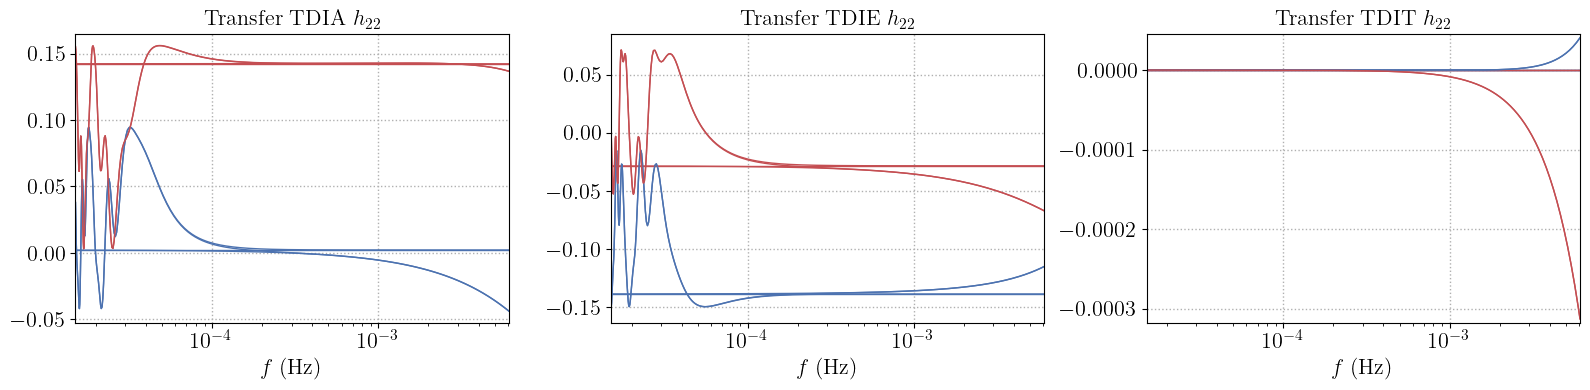

<Figure size 800x400 with 0 Axes>

In [142]:
Mstr = 'M1e7'

# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[Mstr][approx][(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    for approx in approx_list:
        plotutils.lloglinearplot(axs[i], [wftdi[Mstr][approx][lm]['freq'], np.real(wftdi[Mstr][approx][lm][transferstr]) * rescaling], [wftdi[Mstr][approx][lm]['freq'], np.imag(wftdi[Mstr][approx][lm][transferstr]) * rescaling])
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
fig.tight_layout()

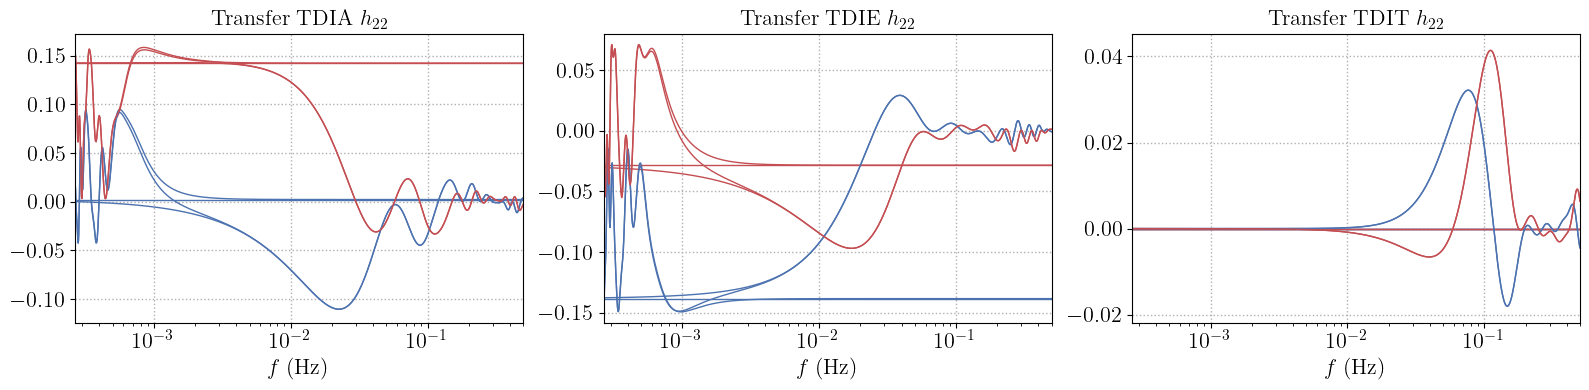

<Figure size 800x400 with 0 Axes>

In [144]:
Mstr = 'M1e5'

# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[Mstr][approx][(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    for approx in approx_list:
        plotutils.lloglinearplot(axs[i], [wftdi[Mstr][approx][lm]['freq'], np.real(wftdi[Mstr][approx][lm][transferstr]) * rescaling], [wftdi[Mstr][approx][lm]['freq'], np.imag(wftdi[Mstr][approx][lm][transferstr]) * rescaling])
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
fig.tight_layout()

## Fisher sky localization

In [152]:
fishercov = {}
sky_area = {}
for Mstr in M_list:
    fishercov[Mstr] = {}
    sky_area[Mstr] = {}
    for approx in approx_list:
        fishercov[Mstr][approx] = lisa_fisher.fisher_covariance_smbh(params_of_M(Mstr), freqs=['nyquist_log', None], steps=None, list_params=list_params, Lframe=True, **waveform_params_approx(waveform_params, approx))
        sky_area[Mstr][approx] = lisatools.sky_area_cov(fishercov[Mstr][approx], sq_deg=True, n_sigma=None, prob=0.90)

In [153]:
sky_area

{'M1e5': {'frozen-lowf': 332.9048753951892,
  'lowf': 39.54650216975393,
  'frozen': 24.30448829236197,
  'full': 15.897417377671857},
 'M1e7': {'frozen-lowf': 0.46560916140887115,
  'lowf': 0.4666396938525019,
  'frozen': 0.2870095280701382,
  'full': 0.28736631418923764}}

## Sky multimodality degeneracies

In [154]:
lnL_skymodes = {}
for Mstr in M_list:
    lnL_skymodes[Mstr] = {}
    for approx in approx_list:
        likelihood = lisa.LikelihoodLISASMBH(params_of_M(Mstr), **waveform_params_approx(waveform_params, approx))
        lnL_skymodes[Mstr][approx] = lisatools.func_loglikelihood_skymodes(likelihood)

In [155]:
lnL_skymodes

{'M1e5': {'frozen-lowf': {(1, 0): 8.731149137020111e-11,
   (-1, 0): 2.6193447411060333e-10,
   (1, 1): 1.3096723705530167e-10,
   (-1, 1): 2.473825588822365e-10,
   (1, 2): 1.8917489796876907e-10,
   (-1, 2): 2.9103830456733704e-11,
   (1, 3): 4.802132025361061e-10,
   (-1, 3): 4.94765117764473e-10},
  'lowf': {(1, 0): 5.820766091346741e-11,
   (-1, 0): -366.7976689962816,
   (1, 1): -328.0857738982595,
   (-1, 1): -654.355157781858,
   (1, 2): -2400.6333630871814,
   (-1, 2): -989.6240854363132,
   (1, 3): -2498.20385510262,
   (-1, 3): -2803.5512354723323},
  'frozen': {(1, 0): -2.9103830456733704e-11,
   (-1, 0): 7.275957614183426e-11,
   (1, 1): -1056.9519940137106,
   (-1, 1): -1056.951994013696,
   (1, 2): -1573.6305645488028,
   (-1, 2): -1573.6305645488173,
   (1, 3): -996.759864374646,
   (-1, 3): -996.7598643746023},
  'full': {(1, 0): 2.9103830456733704e-11,
   (-1, 0): -367.5287102245784,
   (1, 1): -1344.8660137633706,
   (-1, 1): -1646.664778592196,
   (1, 2): -4065.8189